## Train the model

Now set up GRPO Trainer and configurations!

As you run the trainer, the goal is to see the various `reward` columns increase.

After 50 steps or more, you may notice some of the reward standard deviations begin to decrease, meaning that the different predictions are starting to converge on solutions that give similar rewards. If your model has learned the task, then you'll see the `correct_answer_reward_function` increase to its highest value (check the function to see what that is).

Here is an example, which successfully converged on a higher reward. Note, the values you see here will probably be different from yours, especially if your reward amounts are different.

| Step | Training Loss | reward   | reward_std | ... | kl      | rewards / correct_answer_reward_function / mean | rewards / correct_answer_reward_function / std |
|------|---------------|----------|------------|-----|---------|------------------------------------------|-----------------------------------------|
| 1    | 0.000000      | 7.961805 | 2.368493   | ... | 0.020369| 0.875000                                 | 1.024695                                |
| 2    | 0.000000      | 7.937500 | 1.352467   | ... | 0.016483| 0.875000                                 | 1.024695                                |
| 3    | 0.000000      | 1.894792 | 6.462189   | ... | 0.013677| 0.375000                                 | 0.806226                                |
| ...  | ...           | ...      | ...        | ... | ...     | ...                                      | ...                                     |
| 398  | 0.000100      | 13.000000| 0.000000   | ... | 0.088529| 2.000000                                 | 0.000000                                |
| 399  | 0.000100      | 13.000000| 0.000000   | ... | 0.088617| 2.000000                                 | 0.000000                                |
| 400  | 0.000100      | 13.000000| 0.000000   | ... | 0.096202| 2.000000                                 | 0.000000                                |


# Project: Teaching an LLM to Reason

In this project, you will teach an LLM to use step-by-step reasoning to answer the question: "How many X's are there in the word Y?"

Counting letters in a word is a surprisingly complex task for an LLM. Just as human beings would not be able to answer such a question for longer words without breaking down the word into its individual letters and then counting them, LLMs cannot be similarly expected to be able to respond without using smaller reasoning steps.

For example, to count the number of o's in the word room, one could use the following reasoning:

```
Question: How many of the letter "o" are there in the word "room"
Answer: 2
Response:

<reasoning>
Letter-by-letter spelling:
1. r - 0 o's so far
2. o - 1 o's so far
3. o - 2 o's so far
4. m - 2 o's so far

The letter "o" appears 2 times in the word "room".
</reasoning>
<answer>
2
</answer>
```

In this project we will use the reinforcement learning method GRPO (Group Relative Policy Optimization, of DeepSeek fame) to take a large language model that has been fine-tuned for following instructions and teach it how to break a word down into its letters and then count the requested letter.

We will complete the following steps:

* Set up the notebook
* Create a letter-counting dataset
* Create the reward functions
* Train the model
* View the results

NOTE: This notebook will have you focus on several important aspects of training a GPRO model using LoRA:

1. Configuring LoRA adapters for parameter-efficient fine tuning
2. Selecting reward functions that help the model efficiently find its way to the correct answer (also called reward shaping)
3. Finding hyperparameters that help the model increase the rewards earned more quickly and reliably
4. Learning how to start with smaller experiments and to work your way up to longer experiments.

## Set up the notebook

We'll install dependencies needed for the project, namely `unsloth` and `vllm`, which are useful for fine-tuning LLMs with even just 15GB of VRAM.

In [1]:
# Load ipython-autotime to see how long each cell take to run
# No changes needed in this cell

!pip install -q ipython-autotime
%load_ext autotime

time: 202 μs (started: 2025-12-25 15:33:47 +00:00)


In [2]:
# Verify we have enough GPU memory to run this project (at least 15360MiB)
# No changes needed in this cell

!nvidia-smi

Thu Dec 25 15:33:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
| N/A   33C    P0             25W /   70W |    1979MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

time: 262 ms (started: 2025-12-25 15:33:51 +00:00)


In [3]:
# Load the `Qwen 2.5 3B Instruct`, and set parameters for the project
# The first time unsloth is imported, it will do its magic and patch the modules
# it works with. This may 2-5 minutes.
# TODO: Fill in the missing parts marked with **********

import unsloth

from unsloth import FastLanguageModel
import torch

max_seq_length = 1024  # # 384 is too short for CoT. 1024 is safe and stable.

# Set the LoRA rank to an appropriate value
# Read about setting LoRA rank:
# https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide

# starting from 32 vs 64to Avoid overfitting and save some VRAM for experiments
# and to test whether the task truly requires that capacity or whether lower-rank adapters generalize better for algorithmic behavior
# Also using Rank 32 saves VRAM, allowing you to increase the Group Size (num_generations).
lora_rank = 32  

# Load the Instruct model in 4-bit mode
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-3B-Instruct",
    max_seq_length=max_seq_length,
    load_in_4bit=True,  # We'll use quantization!
    fast_inference=True,  # This uses vllm for faster inference
    max_lora_rank=lora_rank,
    gpu_memory_utilization=0.5,  # You can reduce this if you get an memory error
)

model = FastLanguageModel.get_peft_model(
    model,
    r=lora_rank,
    target_modules=[
        # Read about choosing adapters for LoRA:
        # https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide
        # Choose the target modules/adapters for your LoRA model
        # ********** # Explain your choice
       
        # Attention projections:
        # - q_proj, k_proj, v_proj enable learning new attention
        #   patterns (e.g., comparing characters and positions).
        # - o_proj integrates attention results back into the model.
        #

        "q_proj",    # Enables tokens to explicitly query whether they match the target letter
        "k_proj",    # Allows character tokens to expose their identity to attention
        "v_proj",    # Propagates match / no-match signals through attention
        "o_proj",    # Integrates attention results (partial counts) into the residual stream
        
        # MLP projections:
        # - up_proj expands hidden states for intermediate reasoning.
        # - gate_proj controls which signals pass through, which is
        #   important for suppressing hallucinations in algorithmic tasks.
        # - down_proj compresses computed signals back into model space.
        "gate_proj", # Controls MLP signal flow to suppress noise and hallucinated counts
        "up_proj",   # Expands hidden states to support intermediate counting computations
        "down_proj", # Compresses and integrates computed counting signals back into the model

    ],
    lora_alpha=lora_rank,
    use_gradient_checkpointing="unsloth",  # Unsloth enables longer contexts
    # See: https://github.com/unslothai/unsloth
)

/voc/data/venv2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
INFO 12-25 15:35:03 [__init__.py:241] Automatically detected platform cuda.
ERROR 12-25 15:35:08 [fa_utils.py:57] Cannot use FA version 2 is not supported due to FA2 is only supported on devices with compute capability >= 8
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 12-25 15:35:43 [vllm_utils.py:688] Unsloth: Patching vLLM v1 graph capture
INFO 12-25 15:35:43 [vllm_utils.py:716] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2025.9.7: Fast Qwen2 patching. Transformers: 4.55.4. vLLM: 0.10.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.563 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM 

2025-12-25 15:36:19,159	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 12-25 15:36:19 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=2048.
Unsloth: vLLM Bitsandbytes config using kwargs = {'load_in_8bit': False, 'load_in_4bit': True, 'bnb_4bit_compute_dtype': 'float16', 'bnb_4bit_quant_storage': 'uint8', 'bnb_4bit_quant_type': 'nf4', 'bnb_4bit_use_double_quant': True, 'llm_int8_enable_fp32_cpu_offload': False, 'llm_int8_has_fp16_weight': False, 'llm_int8_skip_modules': ['lm_head', 'multi_modal_projector', 'merger', 'modality_projection', 'model.layers.2.mlp', 'model.layers.3.mlp', 'model.layers.30.mlp'], 'llm_int8_threshold': 6.0}
INFO 12-25 15:36:19 [llm_engine.py:222] Initializing a V0 LLM engine (v0.10.1) with config: model='unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit', speculative_config=None, tokenizer='unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_le

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:02<00:00,  2.16s/it]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:02<00:00,  2.16s/it]

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:17<00:00, 17.69s/it]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:17<00:00, 17.69s/it]


INFO 12-25 15:36:43 [punica_selector.py:19] Using PunicaWrapperGPU.


INFO 12-25 15:36:43 [model_runner.py:1112] Model loading took 2.3277 GiB and 21.341131 seconds
INFO 12-25 15:36:47 [worker.py:295] Memory profiling takes 3.79 seconds
INFO 12-25 15:36:47 [worker.py:295] the current vLLM instance can use total_gpu_memory (14.56GiB) x gpu_memory_utilization (0.42) = 6.06GiB
INFO 12-25 15:36:47 [worker.py:295] model weights take 2.33GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 0.88GiB; the rest of the memory reserved for KV Cache is 2.82GiB.
INFO 12-25 15:36:48 [executor_base.py:114] # cuda blocks: 5140, # CPU blocks: 0
INFO 12-25 15:36:48 [executor_base.py:119] Maximum concurrency for 1024 tokens per request: 80.31x
INFO 12-25 15:36:48 [vllm_utils.py:721] Unsloth: Running patched vLLM v0 `capture_model`.
INFO 12-25 15:36:48 [model_runner.py:1383] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eag

Capturing CUDA graph shapes: 100%|██████████| 23/23 [00:11<00:00,  2.07it/s]

INFO 12-25 15:36:59 [model_runner.py:1535] Graph capturing finished in 11 secs, took 0.49 GiB
INFO 12-25 15:36:59 [vllm_utils.py:728] Unsloth: Patched vLLM v0 graph capture finished in 11 secs.


INFO 12-25 15:37:00 [llm_engine.py:417] init engine (profile, create kv cache, warmup model) took 16.36 seconds
INFO 12-25 15:37:00 [llm.py:298] Supported_tasks: ['generate']
Unsloth: Just some info: will skip parsing ['q_norm', 'norm1', 'norm2', 'post_feedforward_layernorm', 'layer_norm1', 'post_layernorm', 'layer_norm2', 'input_layernorm', 'k_norm', 'post_attention_layernorm', 'pre_feedforward_layernorm']
Unsloth: Just some info: will skip parsing ['q_norm', 'norm1', 'norm2', 'post_feedforward_layernorm', 'layer_norm1', 'cross_attn_input_layernorm', 'post_layernorm', 'layer_norm2', 'input_layernorm', 'k_norm', 'post_attention_layernorm', 'cross_attn_post_attention_layernorm', 'pre_feedforward_layernorm']


Unsloth 2025.9.7 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


time: 2min 48s (started: 2025-12-25 15:34:22 +00:00)


## Try Prompt Engineering to Count Letters

Let's work on the system prompt a little to see if we can get the model to count the number of the letter `g` in `engage`.


Here you must:
* Write clear instructions
* Break the problem down into steps (Chain-of-Thought prompting)
* Provide at least one example for the model to follow (Few-shot prompting)

In [4]:
# First, let's see what happens when we have a blank system prompt
# No changes needed in this cell
SYSTEM_PROMPT = """"""
USER_PROMPT = 'How many of the letter "g" are there in the word "engage"'

# Convert the chat messages to a single string so the model can complete it
text_for_completion = tokenizer.apply_chat_template(
    conversation=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {
            "role": "user",
            "content": USER_PROMPT,
        },
    ],
    tokenize=False,
    add_generation_prompt=True,
)

from vllm import SamplingParams

# Set the LLM sampling parameters
sampling_params = SamplingParams(
    temperature=0.8,
    top_p=0.95,
    max_tokens=2048,
)

# Generate the text completion
output = (
    model.fast_generate(
        [text_for_completion],
        sampling_params=sampling_params,
        lora_request=None,
    )[0]
    .outputs[0]
    .text
)

# Print the text input for the model and the model's output
print("=== TEXT FOR COMPLETION ===")
print(text_for_completion)
print("=== GENERATED OUTPUT ===")
print(output)

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, est. speed input: 44.30 toks/s, output: 22.91 toks/s]

=== TEXT FOR COMPLETION ===
<|im_start|>system
<|im_end|>
<|im_start|>user
How many of the letter "g" are there in the word "engage"<|im_end|>
<|im_start|>assistant

=== GENERATED OUTPUT ===
In the word "engage", there is only one letter "g".
time: 664 ms (started: 2025-12-25 15:40:46 +00:00)


Without any prompting the model will generate an output such as this:

```
=== GENERATED OUTPUT ===
There is one letter "g" in the word "engage".
```

Now let's work on the system prompt to help the model break this problem down into steps, which might help it get the right answer (2 `g`'s in `engage`)

In [6]:
# Let's work on a new system prompt that will help the model break this problem
# down into steps, for example, using "letter-by-letter" spelling.
# TODO: Fill in the missing parts marked with **********

# Use a CoT prompt with at least one example
SYSTEM_PROMPT = """
You are a precise counting engine. To count letters accurately, you must first index the word character by character.

Respond in the following format:
<reasoning>
Target Word: [word]
Indexed:
1: [char]
2: [char]
3: [char]
...

Count logic:
1. [char] - [count of requested letter so far]
2. [char] - [count of requested letter so far]
...
The letter "[letter]" appears [number] times in the word "[word]".
</reasoning>
<answer>
[number]
</answer>

Example 1:
<reasoning>
Target Word: rule
Indexed:
1: r
2: u
3: l
4: e

Count logic:
1. r - 0
2. u - 0
3. l - 0
4. e - 1
The letter "e" appears 1 times in the word "rule".
</reasoning>
<answer>
1
</answer>

Example 2:
<reasoning>
Target Word: banana
Indexed:
1: b
2: a
3: n
4: a
5: n
6: a

Count logic:
1. b - 0
2. a - 1
3. n - 1
4. a - 2
5. n - 2
6. a - 3
The letter "a" appears 3 times in the word "banana".
</reasoning>
<answer>
3
</answer>
"""


USER_PROMPT = 'How many of the letter "g" are there in the word "engage"'

# Convert the chat messages to a single string so the model can complete it
text_for_completion = tokenizer.apply_chat_template(
    conversation=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {
            "role": "user",
            "content": USER_PROMPT,
        },
    ],
    tokenize=False,
    add_generation_prompt=True,
)

from vllm import SamplingParams

# Set the LLM sampling parameters
sampling_params = SamplingParams(
    temperature=0.8,
    top_p=0.95,
    max_tokens=2048,
)

# Generate the text completion
output = (
    model.fast_generate(
        [text_for_completion],
        sampling_params=sampling_params,
        lora_request=None,
    )[0]
    .outputs[0]
    .text
)

# Print the text input for the model and the model's output
print("=== TEXT FOR COMPLETION ===")
print(text_for_completion)
print("=== GENERATED OUTPUT ===")
print(output)

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 116.36 toks/s, output: 40.02 toks/s]

=== TEXT FOR COMPLETION ===
<|im_start|>system

You are a precise counting engine. To count letters accurately, you must first index the word character by character.

Respond in the following format:
<reasoning>
Target Word: [word]
Indexed:
1: [char]
2: [char]
3: [char]
...

Count logic:
1. [char] - [count of requested letter so far]
2. [char] - [count of requested letter so far]
...
The letter "[letter]" appears [number] times in the word "[word]".
</reasoning>
<answer>
[number]
</answer>

Example 1:
<reasoning>
Target Word: rule
Indexed:
1: r
2: u
3: l
4: e

Count logic:
1. r - 0
2. u - 0
3. l - 0
4. e - 1
The letter "e" appears 1 times in the word "rule".
</reasoning>
<answer>
1
</answer>

Example 2:
<reasoning>
Target Word: banana
Indexed:
1: b
2: a
3: n
4: a
5: n
6: a

Count logic:
1. b - 0
2. a - 1
3. n - 1
4. a - 2
5. n - 2
6. a - 3
The letter "a" appears 3 times in the word "banana".
</reasoning>
<answer>
3
</answer>
<|im_end|>
<|im_start|>user
How many of the letter "g" are th

Did your new prompt get the right answer? Did the model follow all of your instructions?

Maybe yes, maybe no. Either way, we'll want the model to reliably complete this challenge. So let's use GRPO to help it!

## Create a letter-counting dataset

To train a model, we'll first need to create a dataset. We'll use the HuggingFace `datasets` package.

In [7]:
# Create a list of words of different lengths
# No changes are needed in this cell.

ALL_WORDS = [
    "idea",
    "glow",
    "rust",
    "maze",
    "echo",
    "wisp",
    "veto",
    "lush",
    "gaze",
    "knit",
    "fume",
    "plow",
    "void",
    "oath",
    "grim",
    "crisp",
    "lunar",
    "fable",
    "quest",
    "verge",
    "brawn",
    "elude",
    "aisle",
    "ember",
    "crave",
    "ivory",
    "mirth",
    "knack",
    "wryly",
    "onset",
    "mosaic",
    "velvet",
    "sphinx",
    "radius",
    "summit",
    "banner",
    "cipher",
    "glisten",
    "mantle",
    "scarab",
    "expose",
    "fathom",
    "tavern",
    "fusion",
    "relish",
    "lantern",
    "enchant",
    "torrent",
    "capture",
    "orchard",
    "eclipse",
    "frescos",
    "triumph",
    "absolve",
    "gossipy",
    "prelude",
    "whistle",
    "resolve",
    "zealous",
    "mirage",
    "aperture",
    "sapphire",
]
# 2. Extended Vocabulary (Real English words to prevent memorization)
# This includes varying lengths and double letters to make it challenging.
extra_words = [
    "bubble", "career", "degree", "feeder", "giggle", "horror", "mirror", "needle", "pepper", "rubber",
    "saddle", "tattle", "vacuum", "yellow", "zipper", "balloon", "cocoon", "coffee", "committee", "raccoon",
    "success", "tattoo", "valley", "bookkeeper", "mississippi", "assessment", "attendance", "possession",
    "beginning", "challenge", "character", "community", "guarantee", "immediate", "necessary", "occasion",
    "occurred", "parallel", "personnel", "recommend", "reference", "schedule", "separate", "tomorrow",
    "umbrella", "vehicle", "villain", "wednesday", "acoustic", "bachelor", "backlog", "bacteria", "balance",
    "balcony", "bankruptcy", "barricade", "behavior", "benefit", "boundary", "broccoli", "calendar", "campaign",
    "capacity", "category", "champion", "channel", "chimney", "circuit", "citizen", "cocktail", "collapse",
    "colleague", "combine", "comedy", "comfort", "command", "comment", "compact", "company", "compare",
    "compete", "complex", "concept", "concern", "concert", "conduct", "confirm", "connect", "consent",
    "consume", "contact", "contain", "content", "contest", "context", "control", "convert", "convict",
    "costume", "council", "counter", "country", "courage", "covered", "cowboy", "cradle", "crafty", "crater",
    "crayon", "create", "credit", "creepy", "cricket", "crisis", "critic", "crowded", "crucial", "crunchy",
    "crystal", "cuckoo", "culture", "cupboard", "curious", "current", "curtain", "custom", "damage", "danger",
    "dazzle", "debate", "debris", "decade", "decay", "deceive", "decide", "declare", "defeat", "defend",
    "define", "degree", "delay", "delight", "deliver", "demand", "demise", "denial", "dentist", "depart",
    "depend", "depict", "deploy", "depths", "deputy", "derive", "desert", "design", "desire", "detail",
    "detect", "detour", "device", "devote", "devour", "dialog", "diesel", "diet", "differ", "digest",
    "digital", "dignity", "dilemma", "dinner", "direct", "divide", "divine", "doctor", "dollar", "domain",
    "donate", "donkey", "double", "doubt", "dozen", "draft", "dragon", "drain", "drama", "drawer", "dream",
    "dress", "drift", "drill", "drink", "drive", "driver", "drone", "drop", "drove", "drown", "drum", "drunk",
    "dryer", "duck", "dump", "dune", "during", "dusk", "dust", "duty", "dwarf", "dwell", "dying", "dynamic",
    "eager", "eagle", "early", "earth", "easel", "east", "easy", "eaten", "echo", "edge", "edit", "educate",
    "effect", "effort", "eight", "either", "eject", "elbow", "elder", "elect", "element", "elephant", "eleven",
    "elite", "empty", "enable", "enact", "end", "energy", "engage", "engine", "enjoy", "enlist", "enough",
    "ensure", "enter", "entire", "entry", "envy", "episode", "equal", "equip", "erase", "error", "erupt",
    "escape", "essay", "estate", "ethics", "ethnic", "evade", "even", "event", "ever", "every", "evict",
    "evil", "evoke", "exact", "exam", "exceed", "excel", "except", "excess", "excite", "exclude", "excuse",
    "execute", "exempt", "exert", "exile", "exist", "exit", "expand", "expect", "expert", "expire", "explain",
    "explode", "exploit", "explore", "export", "expose", "express", "extend", "extent", "extra", "extreme"
]

ALL_WORDS = list(set(ALL_WORDS + extra_words))

print(len(ALL_WORDS))

ALL_WORDS[:10]

360


['deceive',
 'colleague',
 'doubt',
 'detect',
 'ethnic',
 'event',
 'either',
 'episode',
 'enter',
 'whistle']

time: 8.25 ms (started: 2025-12-25 15:56:17 +00:00)


In [8]:
# Create the dataset as a Hugging Face Dataset using Dataset.from_generator
# No changes needed in this cell

from datasets import Dataset
import random


# Go through the letters from the words (as well as letters not in the words),
# and create a labelled dataset with all the different combinations.
# For example for the word gaze:
# 1. How many i's are in idea? <-- count should be 1
# 2. How many d's are in idea? <-- count should be 1
# 3. How many e's are in idea? <-- count should be 1
# 4. How many a's are in idea? <-- count should be 1
# 5. How many b's are in idea? <-- a letter not in word (count should be zero)
def generate_records():
    for word in ALL_WORDS:
        for letter in sorted(set(word)):
            yield {"words": word, "letters": letter, "counts": word.count(letter)}

        # pick random letters not in the word
        num_letters_not_in_word_left = int(len(word) // 7 + 1)

        random.seed(hash(word))

        all_letters = list("abcdefghijklmnopqrstuvwxyz")

        random.shuffle(all_letters)
        for letter in all_letters:
            if letter not in word:
                yield {"words": word, "letters": letter, "counts": 0}
                num_letters_not_in_word_left -= 1
            if num_letters_not_in_word_left == 0:
                break


ds = Dataset.from_generator(generate_records)

# Show the first item
ds[0]

Generating train split: 2402 examples [00:00, 85734.99 examples/s]


{'words': 'deceive', 'letters': 'c', 'counts': 1}

time: 376 ms (started: 2025-12-25 15:56:34 +00:00)


In [9]:
# Add the entire prompt (system + user) and the answer to the dataset
# We'll use a prompt that spells out the word letter-by-letter
# No changes needed in this cell

# Updated Cell to apply the correct System Prompt with Examples
import re
from datasets import load_dataset, Dataset

# --- SYSTEM PROMPT WITH EXAMPLES (FEW-SHOT) ---
SYSTEM_PROMPT = """
You are a precise counting engine. To count letters accurately, you must first index the word character by character.

Respond in the following format:
<reasoning>
Target Word: [word]
Indexed:
1: [char]
2: [char]
...

Count logic:
1. [char] - [count of requested letter so far]
2. [char] - [count of requested letter so far]
...
The letter "[letter]" appears [number] times in the word "[word]".
</reasoning>
<answer>
[number]
</answer>

Example 1:
<reasoning>
Target Word: rule
Indexed:
1: r
2: u
3: l
4: e

Count logic:
1. r - 0
2. u - 0
3. l - 0
4. e - 1
The letter "e" appears 1 times in the word "rule".
</reasoning>
<answer>
1
</answer>

Example 2:
<reasoning>
Target Word: banana
Indexed:
1: b
2: a
3: n
4: a
5: n
6: a

Count logic:
1. b - 0
2. a - 1
3. n - 1
4. a - 2
5. n - 2
6. a - 3
The letter "a" appears 3 times in the word "banana".
</reasoning>
<answer>
3
</answer>
"""

# Apply the CORRECT prompt to the dataset
ds = ds.map(
    lambda x: {
        "prompt": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {
                "role": "user",
                "content": 'How many of the letter "{}" are there in the word "{}"'.format(
                    x["letters"], x["words"]
                ),
            },
        ],
    }
)

# VERIFY IT: This must show the full prompt with examples
print("Checking the first prompt to ensure it has 'Indexed:' and Examples...")
print(ds[0]["prompt"][0]["content"])

Map: 100%|██████████| 2402/2402 [00:00<00:00, 9640.61 examples/s] 

Checking the first prompt to ensure it has 'Indexed:' and Examples...

You are a precise counting engine. To count letters accurately, you must first index the word character by character.

Respond in the following format:
<reasoning>
Target Word: [word]
Indexed:
1: [char]
2: [char]
...

Count logic:
1. [char] - [count of requested letter so far]
2. [char] - [count of requested letter so far]
...
The letter "[letter]" appears [number] times in the word "[word]".
</reasoning>
<answer>
[number]
</answer>

Example 1:
<reasoning>
Target Word: rule
Indexed:
1: r
2: u
3: l
4: e

Count logic:
1. r - 0
2. u - 0
3. l - 0
4. e - 1
The letter "e" appears 1 times in the word "rule".
</reasoning>
<answer>
1
</answer>

Example 2:
<reasoning>
Target Word: banana
Indexed:
1: b
2: a
3: n
4: a
5: n
6: a

Count logic:
1. b - 0
2. a - 1
3. n - 1
4. a - 2
5. n - 2
6. a - 3
The letter "a" appears 3 times in the word "banana".
</reasoning>
<answer>
3
</answer>

time: 262 ms (started: 2025-12-25 15:56:42 +00:

In [10]:
# Let's see how well the model runs out-of-the-box
# No changes needed in this cell

text = tokenizer.apply_chat_template(
    ds[0]["prompt"], tokenize=False, add_generation_prompt=True
)

from vllm import SamplingParams

sampling_params = SamplingParams(
    temperature=0.8,
    top_p=0.95,
    max_tokens=1024,
)
output = (
    model.fast_generate(
        [text],
        sampling_params=sampling_params,
        lora_request=None,
    )[0]
    .outputs[0]
    .text
)

print(output)

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it, est. speed input: 95.43 toks/s, output: 39.62 toks/s]

<reasoning>
Target Word: conceive
Indexed:
1: c
2: o
3: n
4: e
5: c
6: e
7: i
8: v
9: e

Count logic:
1. c - 0
2. o - 0
3. n - 0
4. e - 1
5. c - 1
6. e - 2
7. i - 2
8. v - 2
9. e - 3
The letter "c" appears 1 times in the word "conceive".
</reasoning>
<answer>
1
</answer>
time: 3.59 s (started: 2025-12-25 15:56:55 +00:00)


## Create Reward Functions

One goal of creating reward functions is to guide the model toward behaviors that help it reach its goal (counting the occurrences of a letter within a word) more easily. Since there is more than one way to carry out any step-by-step task (e.g. whether or not you use bullet points to separate your steps), there's a bit of judgement involved in choosing what behaviors to reward, i.e. how do we provide partial credit or "shape" our rewards?

In this case we will encourage the model to (whether or not this structure is best):
* use numbers for bullet points when spelling out the word
* to spell the word correctly
* to count the requested letter correctly
* to use the requested reasoning format
* to get the final answer correct.


### Numbering reward function

In [11]:
# Let's work on a function that the numbering in the bullet points is correct
# When using GRPO, we lean on reward functions that are relatively easy to
# compute, thus removing the need to have a second large model just for
# evaluation.
# In this case, we'll use regular expressions quite a bit.
# TODO: Fill in the missing parts marked with **********
import re

def extract_letter_numbering(response):
    """Extract the numbers at the beginning of the line

    Example:
    1. g - 1 so far
    2. o - 1 so far
    3. a - 2 so far
    4. a - 2 so far
    5. l - 2 so far
    returns [1, 2, 3, 4, 5]
    """
    import re

    # We use a regular expression to find lines of the form:
    # '\n[number]. [letter]'
    # pattern = r"\n(\d+). [a-z]"
    pattern = r"\n(\d+)\. [a-z]"


    # Use `re` to find all matches of the pattern in the response
    # matches = **********
    matches = re.findall(pattern, response, flags=re.IGNORECASE)

    if matches:
        return [int(m) for m in matches]
    return []


assert extract_letter_numbering(
    """
1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
4. a - 2 so far
5. l - 2 so far
"""
) == [1, 2, 3, 4, 5]


def numbering_reward_func(completions, words, **kwargs) -> list[float]:
    """Provides a reward for getting the numbering at the beginning of the line correct

    1. g - 1 so far <-- Good in-order numbering
    2. o - 1 so far <-- Good in-order numbering
    3. a - 2 so far <-- Good in-order numbering
    3. l - 2 so far <-- Bad numbering, out-of-order, 3 should be 4
    1. l - 2 so far <-- Bad numbering, extra letter and out-of-order
    1. l - 2 so far <-- Bad numbering, extra letter and out-of-order

    """
    responses = [completion[0]["content"] for completion in completions]

    res = []
    for response, word in zip(responses, words):
        reward = 0

        for ix, spell_number in enumerate(extract_letter_numbering(response)):
            line_number = ix + 1

            # Get points for in-order numbering
            if spell_number == line_number:
                # TODO: Provide a reward for in-order numbering
                # (positive for good behavior, negative for bad)
                reward += 0.5
            # Otherwise lose points
            else:
                # TODO: Provide a reward for out-of-order numbering
                # (positive for good behavior, negative for bad)
                reward -= 0.5

            # Lose extra points for continuing beyond the length of the word
            if line_number > len(word):  # We use the index of the line
                # TODO: Provide a reward for continuing beyond the length of the word
                # (positive for good behavior, negative for bad)
                reward -= 1.0

        res.append(reward / len(word))
    return res


res = numbering_reward_func(
    completions=[
        [
            {  # Worse response
                "content": """<reasoning>
Here is a letter by letter spelling:
1. g - 1 so far <-- Good in-order numbering
2. o - 1 so far <-- Good in-order numbering
3. a - 2 so far <-- Good in-order numbering
3. l - 2 so far <-- Bad numbering, out-of-order, 3 should be 4
1. l - 2 so far <-- Bad numbering, extra letter and out-of-order
1. l - 2 so far <-- Bad numbering, extra letter and out-of-order
</reasoning>
<answer>2</answer>"""
            },
        ],
        [
            {  # Better response
                "content": """<reasoning>
Here is a letter by letter spelling:
1. g - 1 so far <-- Good in-order numbering
2. o - 1 so far <-- Good in-order numbering
3. a - 2 so far <-- Good in-order numbering
3. l - 2 so far <-- Bad numbering, out-of-order, 3 should be 4
</reasoning>
<answer>2</answer>"""
            },
        ],
    ],
    words=["goal", "goal"],
)
print(res)

assert res[1] > res[0], "The better response should have a higher reward"

[-0.5, 0.25]
time: 2.99 ms (started: 2025-12-25 15:56:59 +00:00)


### Spelling reward function

In [12]:
# redefined spelling function to fit new prompt logic
def extract_spelling(response):
    """Extract the spelling strictly from the 'Indexed:' section (using colons).
    
    Target format:
    1: g
    2: o
    3: a
    4: l
    """
    import re

    # FIX: Use a strict literal colon ':' instead of the wildcard '.'
    # This prevents double-counting the 'Count logic' section.
    pattern = r"\n\d+: ([a-z])"
    
    matches = re.findall(pattern, response, flags=re.IGNORECASE)
    
    # Fallback: If no colons found, try looking for the count section (dots)
    # but strictly escaped dots "\."
    if not matches:
        pattern_dot = r"\n\d+\. ([a-z])"
        matches = re.findall(pattern_dot, response, flags=re.IGNORECASE)
        
    if matches:
        return "".join([m for m in matches])
    return ""


# Test it to make sure it handles your new prompt format
test_str = """
Indexed:
1: g
2: o
3: a
4: l

Count logic:
1. g - 0
2. o - 0
3. a - 0
4. l - 0
"""
# This should now return "goal", NOT "goalgoal"
print(f"Extracted: {extract_spelling(test_str)}") 
assert extract_spelling(test_str) == "goal"


def spelling_reward_func(completions, words, **kwargs) -> list[float]:
    """A spelling reward function."""
    from collections import Counter

    responses = [completion[0]["content"] for completion in completions]

    res = []

    for word, response in zip(words, responses):
        reward = 0.0
        
        # Lowercase everything to avoid penalties for 'G' vs 'g'
        word = word.lower()
        resp_spelling = extract_spelling(response).lower()

        # Provide a reward for exactly correct spelling
        if resp_spelling == word:
            reward += 2.0
            res.append(reward)
            continue # Skip penalties if perfect

        # Provide a reward for each letter of difference in length
        reward -= 0.5 * abs(len(resp_spelling) - len(word))

        resp_counter = Counter(resp_spelling)
        word_counter = Counter(word)

        # Provide a reward for each letter that is not in the target word
        extras = sum(max(resp_counter[c] - word_counter.get(c, 0), 0) for c in resp_counter)
        reward -= 1.0 * extras

        # Provide a reward for each letter that is in the target word but not in the response
        missing = sum(max(word_counter[c] - resp_counter.get(c, 0), 0) for c in word_counter)
        reward -= 0.5 * missing

        res.append(reward)
    return res

# Verify logic
res = spelling_reward_func(
    completions=[
        [{"content": test_str}], # Perfect input
        [{"content": "Indexed:\n1: g\n2: o\n"}] # Bad input (missing letters)
    ],
    words=["goal", "goal"],
)

print(res)
assert res[0] == 2.0

Extracted: goal
[2.0, -2.0]
time: 2.98 ms (started: 2025-12-25 15:57:03 +00:00)


### Counting reward function

In [13]:
# Let's reward the model for properly counting the occurrences of a letter in a word
# TODO: Fill in the missing parts marked with **********
# No changes needed in this cell, but feel free to experiment with variations on the prompt


def get_resp_letters_and_counts(response):
    """Extract the letters and counts from the response

    Example:
    1. g - 1 so far
    2. o - 1 so far
    3. a - 2 so far
    4. a - 2 so far
    5. l - 2 so far
    returns [('g', 1), ('o', 1), ('a', 2), ('a', 2), ('l', 2)]
    """
    import re

    pattern = r"\n(\d+)\. ([a-z])\D*(\d+)"

    # Find strings matching e.g. "2. a - 2 so far"
    matches = re.findall(pattern, response, flags=re.IGNORECASE)

    if not matches:
        return []

    return [
        (matched_letter, matched_count_so_far)
        for _, matched_letter, matched_count_so_far in matches
    ]


assert get_resp_letters_and_counts(
    """
1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
4. a - 2 so far
5. l - 2 so far
"""
) == [("g", "1"), ("o", "1"), ("a", "2"), ("a", "2"), ("l", "2")]

# Change: compare claimed counts to the true word instead of the model’s own spelling,
# so we reward correct counting even if the model mis-spells. Also penalize extra lines
# beyond the word length and normalize the score for stability.

def counting_reward_func(completions, letters, words, **kwargs) -> list[float]:
    # Compare the model's claimed running counts to the ground-truth word, not its own spelling.
    responses = [completion[0]["content"] for completion in completions]

    res = []

    # Iterate over each letter-word-response triple
    for letter, word, response in zip(letters, words, responses):
        reward = 0

        letters_and_counts = get_resp_letters_and_counts(response)

        # If there are no numbered lines, penalize and skip
        if not letters_and_counts:
            res.append(-1)
            continue

        expected_count = 0
        for idx, (_, resp_count) in enumerate(letters_and_counts):
            # Update the true running total only when the ground-truth word
            # has the target letter at this position.
            if idx < len(word) and word[idx].lower() == letter.lower():

                expected_count += 1

            # Reward if the model's claimed running total matches the true total so far
            if int(resp_count) == expected_count:
                reward += 1
            else:
                reward -= 1

            # Penalize extra lines beyond the word length
            if idx >= len(word):
                reward -= 1

        # Normalize by parsed lines to keep scale stable
        res.append(reward / len(letters_and_counts))
    return res


res = counting_reward_func(
    completions=[
        [  # Worse response
            {
                "content": """<reasoning>\nHere is a letter by letter spelling:

1. g - 0 so far
2. o - 0 so far
3. a - 1 so far
4. a - 2 so far
5. l - 0 so far

\n</reasoning>\n<answer>\nThis is my answer.\n</answer>"""
            }
        ],
        [  # Better response
            {
                "content": """<reasoning>\nHere is a letter by letter spelling:

1. g - 1 so far
2. o - 1 so far
3. a - 1 so far
4. a - 1 so far
5. l - 1 so far

\n</reasoning>\n<answer>\nThis is my answer.\n</answer>"""
            }
        ],
    ],
    letters=["g", "g"],
    words=["goal", "goal"],
)

print(res)

assert res[1] > res[0], "The better response should have a higher reward"


[-0.8, 0.8]
time: 3.52 ms (started: 2025-12-25 15:57:08 +00:00)


### Formatting reward functions



In [15]:
# Reward the model for providing the response in a specific format
# TODO: Fill in the missing parts marked with **********


def extract_xml_answer(text: str) -> str:
    """Extracts the string between <answer> and </answer> tags."""
    import re

    pattern = r"<answer>(.*?)</answer>"
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group(1).strip()
    return ""


assert (
    extract_xml_answer("""
<reasoning>
This is my reasoning.
</reasoning>
<answer>SUPERCALIFRAGILISTICEXPIALIDOCIOUS</answer>
""")
    == "SUPERCALIFRAGILISTICEXPIALIDOCIOUS"
)


def format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"\s*<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"

    res = []

    for completion in completions:
        reward = 0.0

        # Extract the response content
        response = completion[0]["content"]

        # Check if the response matches the pattern
        match = re.match(pattern, response, flags=re.MULTILINE | re.DOTALL)

        # If it matches, return 0.5, otherwise return 0.0
        # if ... **********
        if match:
            reward += 0.5
        # Extract the answer from the response
        # extracted_answer = **********
        extracted_answer = extract_xml_answer(response)
        # If the answer is an integer, add 0.5 to the reward
        # if ... **********
        if extracted_answer.isdigit():
            reward += 0.5

        res.append(reward)
    return res


res = format_reward_func(
    completions=[
        [{"content": "This is my answer"}],
        [
            {
                "content": "<reasoning>\nThis is my reasoning.\n</reasoning>\n<answer>\n3\n</answer>"
            }
        ],
    ]
)

print(res)

assert res[1] > res[0], "The better response should have a higher reward"

[0.0, 1.0]
time: 2.45 ms (started: 2025-12-25 15:57:17 +00:00)


### Task correctness reward function

In [16]:
# Reward the model for providing the correct answer
# TODO: Fill in the missing parts marked with **********


def correct_answer_reward_func(prompts, completions, counts, **kwargs) -> list[float]:
    """Reward the final answer if it is correct."""
    responses = [completion[0]["content"] for completion in completions]

    extracted_responses = [extract_xml_answer(r) for r in responses]

    # Print a nice summary of the first prompt, answer, and response to see while training
    print(f"""
{"-" * 20}
Question: {prompts[0][-1]["content"]}
Answer: {counts[0]}
Response: {responses[0]}
Extracted: {extracted_responses[0]}
Correct: {str(extracted_responses[0]) == str(counts[0])}!
    """)

    res = [
        # Provide reward for exactly correct answer
        # **********  # Complete the list comprehension
        (2.0 if str(r) == str(a) else -1.0)
        for r, a in zip(extracted_responses, counts)
    ]
    return res


res = correct_answer_reward_func(
    prompts=[
        [{"content": """How many..."""}],
        [{"content": """How many..."""}],
    ],
    completions=[
        [{"content": """<reasoning>.../reasoning>\n<answer>\n3\n</answer>"""}],
        [{"content": """<reasoning>.../reasoning>\n<answer>\n3\n</answer>"""}],
    ],
    letters=["g", "g"],
    counts=[0, 3],
)

print(res)

assert res[1] > res[0], "The better response should have a higher reward"


--------------------
Question: How many...
Answer: 0
Response: <reasoning>.../reasoning>
<answer>
3
</answer>
Extracted: 3
Correct: False!
    
[-1.0, 2.0]
time: 1.84 ms (started: 2025-12-25 15:57:21 +00:00)


### List the reward functions

In [17]:
# List out the reward functions we will use
# No changes needed in this cell

REWARD_FUNCS = [
    numbering_reward_func,
    spelling_reward_func,
    counting_reward_func,
    format_reward_func,
    correct_answer_reward_func,
]

time: 441 μs (started: 2025-12-25 15:57:24 +00:00)


In [20]:
# Fill in the GRPO Parameters we'll use throughout this project
# TODO: Fill in the missing parts marked with **********

# Read about the GRPO params here https://huggingface.co/docs/trl/main/en/grpo_trainer
COMMON_GRPO_TRAINING_PARAMS = dict(
    # Set appropriate values for `learning_rate` and `beta`
    # See: https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide
    # See: https://huggingface.co/docs/trl/main/en/grpo_trainer
    learning_rate=1e-5, 
    beta=0.01, # The model moves with more "confidence" toward the rewards, but the Beta leash ensures it stays linguistically coherent. 
                # This combination is much better at teaching logical reasoning. 

    # Set the batch size appropriately for your hardware. For GRPO there are a number of parameters to set.
    # If you are not sure about your GPU, assume you have a T4. See the memory specs here:
    # https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/tesla-product-literature/T4%20Product%20Brief.pdf
    per_device_train_batch_size = 8,  # per_device_train_batch_size / num_generations determines the number of simultaneous prompts to consider.
    # Note: Set per_device_train_batch_size to at most 16 on the Vocareum T4 for best stability
    num_generations=8,  # More samples = better GRPO statistics.  # Determines the number of completions/generations to compute for each single prompt
    gradient_accumulation_steps=4,  # This parameter allow us to consider multiple steps in a single optimization step
    adam_beta1=0.9,
    adam_beta2=0.99,
    weight_decay=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    optim="adamw_8bit",
    logging_steps=1,
    max_prompt_length=512, # changet that to fit new prompt
    max_completion_length=512, # changet that to fit new CoT
    num_train_epochs=1,  # Set to 1 for a full training run
    save_steps=250,
    max_grad_norm=0.1,
    report_to="none",  # Setting this value lets us use Weights and Biases
    output_dir="outputs",
    use_vllm=True,  # vll speeds up inference! See https://github.com/vllm-project/vllm
)

time: 1.05 ms (started: 2025-12-25 15:58:07 +00:00)


### Quick train

Let's train the model for just 5 steps (`max_steps=5`). As it runs we can double check we've set up our prompts correctly before running for a longer amount of time.

In [21]:
# Train for just a few steps for a few minutes
# This will allow us to observe the results and make any changes to our reward functions
# before starting a longer run. Note, you won't see much change in the average.
# reward values
# No changes are needed here

from trl import GRPOConfig, GRPOTrainer

# Short train to check on reward functions
training_args = GRPOConfig(
    **COMMON_GRPO_TRAINING_PARAMS,
    # We'll just run for a modest 5 steps to make sure everything works and to
    # estimate the amount of time it will take to run the full training.
    max_steps=5,
)
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=REWARD_FUNCS,
    args=training_args,
    train_dataset=ds,
)
trainer_res = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,402 | Num Epochs = 1 | Total steps = 5
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 4 x 1) = 32
 "-____-"     Trainable parameters = 59,867,136 of 3,145,805,824 (1.90% trained)



--------------------
Question: How many of the letter "k" are there in the word "counter"
Answer: 0
Response: <reasoning>
Target Word: counter
Indexed:
1: c
2: o
3: u
4: n
5: t
6: e
7: r

Count logic:
1. c - 0
2. o - 0
3. u - 0
4. n - 0
5. t - 0
6. e - 0
7. r - 0
The letter "k" appears 0 times in the word "counter".
</reasoning>
<answer>
0
</answer>
Extracted: 0
Correct: True!
    
Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / numbering_reward_func / mean,rewards / numbering_reward_func / std,rewards / spelling_reward_func / mean,rewards / spelling_reward_func / std,rewards / counting_reward_func / mean,rewards / counting_reward_func / std,rewards / format_reward_func / mean,rewards / format_reward_func / std,rewards / correct_answer_reward_func / mean,rewards / correct_answer_reward_func / std
1,0.000000,2.250818,0.991161,115.093750,75.000000,142.000000,0.000000,115.093750,75.000000,142.000000,0.000004,0.460938,0.063955,-0.125000,2.214323,0.321131,0.573489,1.000000,0.000000,0.593750,1.521022
2,0.000000,-0.372011,2.185507,120.531250,98.000000,141.000000,0.000000,120.531250,98.000000,141.000000,0.000010,0.419643,0.055096,-2.265625,1.995901,0.348971,0.541890,1.000000,0.000000,0.125000,1.475608
3,0.000000,3.523115,1.805668,107.312500,73.000000,141.000000,0.000000,107.312500,73.000000,141.000000,0.000015,0.442708,0.084636,0.546875,2.404161,0.189782,0.754391,1.000000,0.000000,1.343750,1.260040
4,0.000000,2.039900,1.112901,110.687500,87.000000,131.000000,0.000000,110.687500,87.000000,131.000000,0.000021,0.494141,0.018509,0.343750,1.789023,-0.204241,0.332538,1.000000,0.000000,0.406250,1.521022
5,0.000000,1.934524,1.556981,120.218750,110.000000,137.000000,0.000000,120.218750,110.000000,137.000000,0.000123,0.456473,0.039264,-1.078125,0.951310,-0.068824,0.536940,1.000000,0.000000,1.625000,1.008032



--------------------
Question: How many of the letter "r" are there in the word "export"
Answer: 1
Response: <reasoning>
Target Word: export
Indexed:
1: e
2: x
3: o
4: p
5: t
6: u
7: r

Count logic:
1. e - 0
2. x - 0
3. o - 0
4. p - 0
5. t - 0
6. u - 0
7. r - 1
The letter "r" appears 1 times in the word "export".
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    

--------------------
Question: How many of the letter "j" are there in the word "combine"
Answer: 0
Response: <reasoning>
Target Word: combine
Indexed:
1: c
2: o
3: m
4: b
5: b
6: i
7: n
8: g
9: e

Count logic:
1. j - 0
2. o - 0
3. m - 0
4. b - 1
5. b - 2
6. i - 3
7. n - 3
8. g - 4
9. e - 5
The letter "j" appears 0 times in the word "combine".
</reasoning>
<answer>
0
</answer>
Extracted: 0
Correct: True!
    

--------------------
Question: How many of the letter "e" are there in the word "mirage"
Answer: 1
Response: <reasoning>
Target Word: mirage
Indexed:
1: m
2: i
3: r
4: a
5: g
6: e

Count logic:
1. m - 0

available columns: dict_keys(['loss', 'grad_norm', 'learning_rate', 'num_tokens', 'completions/mean_length', 'completions/min_length', 'completions/max_length', 'completions/clipped_ratio', 'completions/mean_terminated_length', 'completions/min_terminated_length', 'completions/max_terminated_length', 'rewards/numbering_reward_func/mean', 'rewards/numbering_reward_func/std', 'rewards/spelling_reward_func/mean', 'rewards/spelling_reward_func/std', 'rewards/counting_reward_func/mean', 'rewards/counting_reward_func/std', 'rewards/format_reward_func/mean', 'rewards/format_reward_func/std', 'rewards/correct_answer_reward_func/mean', 'rewards/correct_answer_reward_func/std', 'reward', 'reward_std', 'frac_reward_zero_std', 'completion_length', 'kl', 'epoch', 'step'])


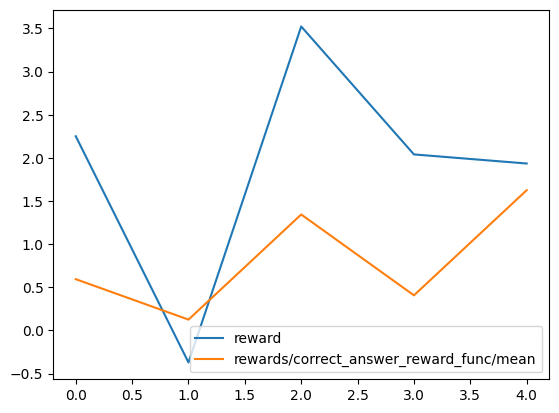

time: 390 ms (started: 2025-12-25 16:01:55 +00:00)


In [22]:
# Show the total (sum) of the rewards as well as the correct_answer_reward_func (means with in the batch)
# No changes needed in this cell

import pandas as pd
import matplotlib.pyplot as plt

# If you want to graph other columns, check these out
print(f"available columns: {trainer.state.log_history[0].keys()}")

log_df = pd.DataFrame(trainer.state.log_history)
log_df["reward"].plot()
log_df["rewards/correct_answer_reward_func/mean"].plot()

# Show the legend
plt.legend(["reward", "rewards/correct_answer_reward_func/mean"])
plt.show()

### Slower train (1+ hour)

If everything looks good, let's go for a longer training session!

In [19]:
# Now let's train for real! Let's do a longer training that will take an hour or more
# Note: If this run is successful, you can consider doing a longer train
# to see what happens, but that's beyond the scope of this project.
# TODO: Fill out the areas where you find **********

# Full training
training_args = GRPOConfig(
    **COMMON_GRPO_TRAINING_PARAMS,
    # Configure the maximum number of steps to take about 30mins of time for
    # a medium-sized experiment. (See how long the previous example took and
    # scale up appropriately using your best guess.)
    max_steps=180,  # 19 sec per run ~60min 
)
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=REWARD_FUNCS,
    args=training_args,
    train_dataset=ds,
)
trainer_res = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,402 | Num Epochs = 1 | Total steps = 180
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 4 x 1) = 32
 "-____-"     Trainable parameters = 59,867,136 of 3,145,805,824 (1.90% trained)



--------------------
Question: How many of the letter "e" are there in the word "contact"
Answer: 0
Response: <reasoning>
Target Word: contact
Indexed:
1: c
2: o
3: n
4: t
5: a
6: c
7: t

Count logic:
1. c - 0
2. o - 0
3. n - 0
4. t - 0
5. a - 1
6. c - 1
7. t - 1
The letter "e" appears 0 times in the word "contact".
</reasoning>
<answer>
0
</answer>
Extracted: 0
Correct: True!
    


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / numbering_reward_func / mean,rewards / numbering_reward_func / std,rewards / spelling_reward_func / mean,rewards / spelling_reward_func / std,rewards / counting_reward_func / mean,rewards / counting_reward_func / std,rewards / format_reward_func / mean,rewards / format_reward_func / std,rewards / correct_answer_reward_func / mean,rewards / correct_answer_reward_func / std
1,0.000000,1.945857,0.983022,132.437500,119.000000,172.000000,0.000000,132.437500,119.000000,172.000000,0.000351,0.439174,0.076250,-0.921875,3.064125,-0.008942,0.688730,1.000000,0.000000,1.437500,1.189673
2,0.000000,1.944393,1.318378,120.625000,88.000000,189.000000,0.000000,120.625000,88.000000,189.000000,0.000380,0.466363,0.070976,-0.750000,3.087435,0.165530,0.821134,1.000000,0.000000,1.062500,1.412787
3,0.000000,0.039875,2.663771,120.781250,97.000000,206.000000,0.000000,120.781250,97.000000,206.000000,0.000168,0.420108,0.094555,-2.093750,3.155736,0.026017,0.703410,1.000000,0.000000,0.687500,1.512048
4,0.000000,1.814459,1.914047,112.437500,87.000000,154.000000,0.000000,112.437500,87.000000,154.000000,0.000242,0.455729,0.041966,-0.734375,2.355448,-0.063145,0.598045,1.000000,0.000000,1.156250,1.370410
5,0.000000,0.669345,1.190454,104.687500,77.000000,120.000000,0.000000,104.687500,77.000000,120.000000,0.000675,0.465774,0.079472,-1.046875,1.872377,0.312946,0.513235,1.000000,0.000000,-0.062500,1.412787
6,0.000000,0.581572,2.020362,112.218750,86.000000,224.000000,0.000000,112.218750,86.000000,224.000000,0.000115,0.457031,0.059634,-0.203125,2.199191,-0.422334,0.624226,1.000000,0.000000,-0.250000,1.319824
7,0.000000,4.284003,1.886898,108.843750,97.000000,120.000000,0.000000,108.843750,97.000000,120.000000,0.000382,0.475521,0.039934,0.921875,1.783026,0.261607,0.493579,1.000000,0.000000,1.625000,1.008032
8,0.000000,0.436942,1.218642,103.312500,75.000000,130.000000,0.000000,103.312500,75.000000,130.000000,0.000146,0.483073,0.036446,-1.046875,2.578945,-0.124256,0.606837,1.000000,0.000000,0.125000,1.475608
9,0.000000,2.688864,1.518537,105.375000,88.000000,141.000000,0.000000,105.375000,88.000000,141.000000,0.000324,0.467857,0.070827,0.515625,2.197815,0.205382,0.561041,1.000000,0.000000,0.500000,1.524001
10,0.000000,1.174293,1.719849,112.406250,78.000000,132.000000,0.000000,112.406250,78.000000,132.000000,0.000935,0.431696,0.088764,-0.687500,1.707432,-0.163653,0.481708,1.000000,0.000000,0.593750,1.521022



--------------------
Question: How many of the letter "m" are there in the word "parallel"
Answer: 0
Response: <reasoning>
Target Word: parallel
Indexed:
1: p
2: a
3: r
4: a
5: l
6: i
7: a
8: n
9: a
10: r

Count logic:
1. p - 0
2. a - 1
3. r - 1
4. a - 2
5. l - 2
6. i - 3
7. a - 3
8. n - 3
9. a - 4
10. r - 4

The letter "m" appears 0 times in the word "parallel".
</reasoning>
<answer>
0
</answer>
Extracted: 0
Correct: True!
    

--------------------
Question: How many of the letter "a" are there in the word "separate"
Answer: 2
Response: <reasoning>
Target Word: separate
Indexed:
1: s
2: e
3: p
4: a
5: r
6: e
7: a
8: t
9: e

Count logic:
1. s - 0
2. e - 1
3. a - 2
4. p - 2
5. c - 2
6. r - 3
7. e - 4
The letter "a" appears 2 times in the word "separate".
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: True!
    

--------------------
Question: How many of the letter "u" are there in the word "drum"
Answer: 1
Response: <reasoning>
Target Word: drum
Indexed:
1: d
2: r
3: u
4: m


available columns: dict_keys(['loss', 'grad_norm', 'learning_rate', 'num_tokens', 'completions/mean_length', 'completions/min_length', 'completions/max_length', 'completions/clipped_ratio', 'completions/mean_terminated_length', 'completions/min_terminated_length', 'completions/max_terminated_length', 'rewards/numbering_reward_func/mean', 'rewards/numbering_reward_func/std', 'rewards/spelling_reward_func/mean', 'rewards/spelling_reward_func/std', 'rewards/counting_reward_func/mean', 'rewards/counting_reward_func/std', 'rewards/format_reward_func/mean', 'rewards/format_reward_func/std', 'rewards/correct_answer_reward_func/mean', 'rewards/correct_answer_reward_func/std', 'reward', 'reward_std', 'frac_reward_zero_std', 'completion_length', 'kl', 'epoch', 'step'])


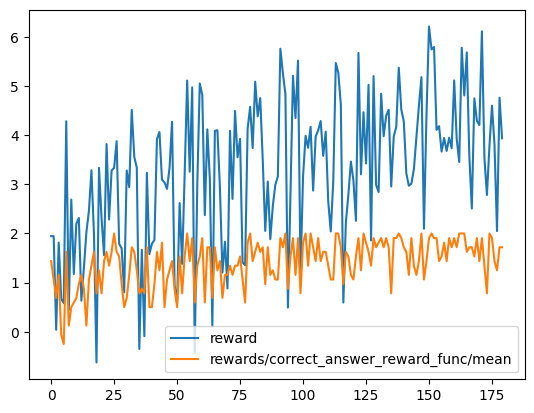

time: 276 ms (started: 2025-12-24 02:53:45 +00:00)


In [ ]:
# Show the total (sum) of the rewards as well as the correct_answer_reward_func (means with in the batch)
# Do you see the rewards increasing? Does the model get the correct answer
# more frequently toward the end?
# No changes needed in this cell

import pandas as pd
import matplotlib.pyplot as plt

# If you want to graph other columns, check these out
print(f"available columns: {trainer.state.log_history[0].keys()}")

log_df = pd.DataFrame(trainer.state.log_history)
log_df["reward"].plot()
log_df["rewards/correct_answer_reward_func/mean"].plot()

# Show the legend
plt.legend(["reward", "rewards/correct_answer_reward_func/mean"])
plt.show()



## View the results
Now let's try the model we just trained!

In [21]:
# Save the LoRA adapters
# No changes needed in this cell

# Save the LoRA model
model.save_lora("grpo_saved_lora")

time: 1.04 s (started: 2025-12-24 02:53:45 +00:00)


In [11]:
# Create a function to run both the original model and the updated model
# No changes needed in this cell


def compare_old_and_new_model(messages):
    from vllm import SamplingParams

    text = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    sampling_params = SamplingParams(
        temperature=0.8,
        top_p=0.95,
        max_tokens=1024,
    )
    old = (
        model.fast_generate(
            text,
            sampling_params=sampling_params,
        )[0]
        .outputs[0]
        .text
    )

    new = (
        model.fast_generate(
            text,
            sampling_params=sampling_params,
            lora_request=model.load_lora("grpo_saved_lora"),
        )[0]
        .outputs[0]
        .text
    )

    print("===OLD===\n")
    print(old)

    print("\n\n===NEW===\n")
    print(new)


time: 896 μs (started: 2025-12-24 09:51:21 +00:00)


### Compare the old and new models on the letter-counting task

In [18]:
# Let's try spelling the first word from the dataset
# TODO: Fill out the areas where you find **********

# Load the first item from the dataset (index 0) and compare the old and new models
# **********
compare_old_and_new_model(ds[0]["prompt"])




Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it, est. speed input: 111.60 toks/s, output: 31.98 toks/s]

===OLD===

<reasoning>
Target Word: cowboy
Indexed:
1: c
2: o
3: w
4: b
5: o
6: y

Count logic:
1. c - 0
2. o - 1
3. w - 1
4. b - 1
5. o - 2
6. y - 2
The letter "b" appears 1 times in the word "cowboy".
</reasoning>
<answer>
1
</answer>


===NEW===

<reasoning>
Target Word: cowboy
Indexed:
1: c
2: o
3: w
4: a
5: y

Count logic:
1. b - 0
2. o - 0
3. w - 0
4. a - 0
5. y - 0
The letter "b" appears 0 times in the word "cowboy".
</reasoning>
<answer>
0
</answer>
time: 5.84 s (started: 2025-12-24 09:59:51 +00:00)


Our model is better at spelling and counter letters in words! Depending on your reward functions, the size of your model, and the amount of steps trained, results may vary.

For about an hour of training time, your model may not be perfect (or maybe it is), but it's definitely moving in the right direction!

### Make sure the model did not forget basic facts

In [13]:
# Let's see if the model still remembers some of the facts from its original training
# TODO: Fill out the areas where you find **********

# Ask both the old and new models a question the model is likely to know,
# e.g. a well-known capital city
# **********

compare_old_and_new_model(
    [
        {"role": "system", "content": "You are a concise assistant."},
        {"role": "user", "content": "What is the capital of France?"},
    ]
)

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s, est. speed input: 49.60 toks/s, output: 15.26 toks/s]

===OLD===

Paris


===NEW===

The capital of France is Paris.
time: 767 ms (started: 2025-12-24 09:51:50 +00:00)


Great job! Congrats on completing the project! 🎉🤗

## Extra mile

While we see significant progress—the model has improved, standard deviation is decreasing, and rewards are trending up—we have not yet reached absolute stability with zero deviation.

To bridge this gap, we have two main avenues for improvement:

1.  **Extended Training:** We could run the fine-tuning for a longer duration (e.g., **400 steps**) to force the model to converge on edge cases.
2.  **Majority Voting (Inference Strategy):** Alternatively, we can implement a voting mechanism. By generating multiple reasoning paths and selecting the most common answer, we can ensure consistent correctness even if the model occasionally hallucinates on a single attempt.

Below, I demonstrate the **Voting Strategy** to show how we can achieve robust results without doubling the training time.

In [25]:
from collections import Counter
import re
from vllm import SamplingParams

def solve_with_majority_voting(user_prompt, num_votes=5):
    """
    Generates 'num_votes' completions using the Fine-Tuned LoRA model.
    Extracts the final answer from each.
    Returns the most common answer.
    """
    
    # 1. Prepare the Prompt
    # We use the same SYSTEM_PROMPT that worked so well in training
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_prompt}
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    # 2. Generate Multiple Responses (Voting)
    # Temperature 0.4: Stable but allows slight variation for voting to correct errors
    sampling_params = SamplingParams(
        temperature=0.4,  
        top_p=0.95,
        max_tokens=1024,
        n=num_votes # Generate 'n' sequences in parallel
    )
    
    # Load the specific adapter saved after training
    outputs = model.fast_generate(
        [text],
        sampling_params=sampling_params,
        lora_request=model.load_lora("grpo_saved_lora"), 
    )
    
    # 3. Extract Answers
    answers = []
    print(f"\n--- 🗳️ Voting on: '{user_prompt}' ---")
    
    for i, candidate in enumerate(outputs[0].outputs):
        response_text = candidate.text
        
        # Regex to find <answer> number </answer>
        match = re.search(r"<answer>\s*(\d+)\s*</answer>", response_text)
        if match:
            ans = match.group(1)
            answers.append(ans)
            print(f"Vote {i+1}: {ans}")
        else:
            print(f"Vote {i+1}: [Parse Error]")
            
    if not answers:
        return "[No Valid Answers]"
    
    # 4. Select Winner
    # Counter finds the most common element
    most_common, count = Counter(answers).most_common(1)[0]
    
    print(f"🏆 Winner: {most_common} (with {count}/{num_votes} votes)")
    return most_common

def test_specific_prompt(test_name, prompt):
    print(f"\n{'='*60}\n 🧪 {test_name}\n{'='*60}")
    print(f"❓ Question: {prompt}")
    
    # 1. OLD MODEL (No LoRA, greedy decoding)
    messages = [{"role": "system", "content": SYSTEM_PROMPT}, {"role": "user", "content": prompt}]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    old_output = model.fast_generate(
        [text],
        sampling_params=SamplingParams(temperature=0.0, max_tokens=256),
        lora_request=None # Disable LoRA
    )[0].outputs[0].text
    
    # Extract answer from old model
    match = re.search(r"<answer>(.*?)</answer>", old_output, re.DOTALL)
    old_ans = match.group(1).strip() if match else "[No formatted answer]"
    
    print(f"\n❌ OLD MODEL (Base): {old_ans}")

    # 2. NEW MODEL (Fine-Tuned + Majority Voting)
    print(f"\n✅ NEW MODEL (Fine-Tuned): Running 5 voters...")
    final_ans = solve_with_majority_voting(prompt)
    
    print(f"\n👉 FINAL RESULT: {final_ans}")

# ==========================================
#  PART 1: EASY TESTS (Baseline Competence)
# ==========================================

# 1. Simple word from prompts
test_specific_prompt("EASY 1: Standard", 'How many of the letter "a" are there in the word "banana"?')

# 2. Short word
test_specific_prompt("EASY 2: Short", 'How many of the letter "o" are there in the word "pool"?')

# 3. Simple Double Letter
test_specific_prompt("EASY 3: Double Letter", 'How many of the letter "p" are there in the word "apple"?')

# 4. First/Last Letter
test_specific_prompt("EASY 4: Edge Case", 'How many of the letter "d" are there in the word "dad"?')

# 5. No occurrences (Simple)
test_specific_prompt("EASY 5: Simple Zero", 'How many of the letter "z" are there in the word "cat"?')

# 6.From Dataset (Simple)
test_specific_prompt("EASY 6: Dataset Sample", ds[10]['prompt'][1]['content'])

# 7.From Dataset (Simple)
test_specific_prompt("EASY 7: Dataset Sample", ds[50]['prompt'][1]['content'])

# ==========================================
#  PART 2: HARD TESTS (Stress Testing)
# ==========================================

# 1. The Internet Famous "Strawberry" Problem (3 r's)
test_specific_prompt(
    "HARD 1: The Meme Killer", 
    'How many of the letter "r" are there in the word "strawberry"?'
)

# 2. The Repetition Nightmare (4 s's, 4 i's)
test_specific_prompt(
    "HARD 2: Long Repetition", 
    'How many of the letter "s" are there in the word "mississippi"?'
)

# 3. The "Zero Trap" (Letter not in word)
test_specific_prompt(
    "HARD 3: The Hallucination Check", 
    'How many of the letter "z" are there in the word "elephant"?'
)

# 4. The "Tennessee" Trap (4 e's, 2 n's, 2 s's)
test_specific_prompt(
    "HARD 4: Double Letter Hell", 
    'How many of the letter "e" are there in the word "Tennessee"?'
)


 🧪 EASY 1: Standard
❓ Question: How many of the letter "a" are there in the word "banana"?


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 127.63 toks/s, output: 40.42 toks/s]



❌ OLD MODEL (Base): 3

✅ NEW MODEL (Fine-Tuned): Running 5 voters...


Processed prompts: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it, est. speed input: 178.18 toks/s, output: 56.43 toks/s]



--- 🗳️ Voting on: 'How many of the letter "a" are there in the word "banana"?' ---
Vote 1: 3
Vote 2: 3
Vote 3: 3
Vote 4: 3
Vote 5: 3
🏆 Winner: 3 (with 5/5 votes)

👉 FINAL RESULT: 3

 🧪 EASY 2: Short
❓ Question: How many of the letter "o" are there in the word "pool"?


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 161.54 toks/s, output: 40.74 toks/s]



❌ OLD MODEL (Base): 2

✅ NEW MODEL (Fine-Tuned): Running 5 voters...


Processed prompts: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it, est. speed input: 217.90 toks/s, output: 54.95 toks/s]



--- 🗳️ Voting on: 'How many of the letter "o" are there in the word "pool"?' ---
Vote 1: 1
Vote 2: 2
Vote 3: 2
Vote 4: 2
Vote 5: 1
🏆 Winner: 2 (with 3/5 votes)

👉 FINAL RESULT: 2

 🧪 EASY 3: Double Letter
❓ Question: How many of the letter "p" are there in the word "apple"?


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 142.28 toks/s, output: 40.47 toks/s]



❌ OLD MODEL (Base): 2

✅ NEW MODEL (Fine-Tuned): Running 5 voters...


Processed prompts: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it, est. speed input: 192.57 toks/s, output: 54.78 toks/s]



--- 🗳️ Voting on: 'How many of the letter "p" are there in the word "apple"?' ---
Vote 1: 2
Vote 2: 2
Vote 3: 2
Vote 4: 2
Vote 5: 2
🏆 Winner: 2 (with 5/5 votes)

👉 FINAL RESULT: 2

 🧪 EASY 4: Edge Case
❓ Question: How many of the letter "d" are there in the word "dad"?


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, est. speed input: 182.67 toks/s, output: 40.18 toks/s]



❌ OLD MODEL (Base): 1

✅ NEW MODEL (Fine-Tuned): Running 5 voters...


Processed prompts: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it, est. speed input: 245.14 toks/s, output: 53.92 toks/s]



--- 🗳️ Voting on: 'How many of the letter "d" are there in the word "dad"?' ---
Vote 1: 1
Vote 2: 1
Vote 3: 1
Vote 4: 1
Vote 5: 1
🏆 Winner: 1 (with 5/5 votes)

👉 FINAL RESULT: 1

 🧪 EASY 5: Simple Zero
❓ Question: How many of the letter "z" are there in the word "cat"?


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, est. speed input: 182.15 toks/s, output: 40.06 toks/s]



❌ OLD MODEL (Base): 0

✅ NEW MODEL (Fine-Tuned): Running 5 voters...


Processed prompts: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it, est. speed input: 244.76 toks/s, output: 53.83 toks/s]



--- 🗳️ Voting on: 'How many of the letter "z" are there in the word "cat"?' ---
Vote 1: 0
Vote 2: 0
Vote 3: 0
Vote 4: 0
Vote 5: 0
🏆 Winner: 0 (with 5/5 votes)

👉 FINAL RESULT: 0

 🧪 EASY 6: Dataset Sample
❓ Question: How many of the letter "r" are there in the word "differ"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 128.00 toks/s, output: 40.79 toks/s]



❌ OLD MODEL (Base): 2

✅ NEW MODEL (Fine-Tuned): Running 5 voters...


Processed prompts: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it, est. speed input: 173.40 toks/s, output: 55.27 toks/s]



--- 🗳️ Voting on: 'How many of the letter "r" are there in the word "differ"' ---
Vote 1: 2
Vote 2: 1
Vote 3: 2
Vote 4: 1
Vote 5: 1
🏆 Winner: 1 (with 3/5 votes)

👉 FINAL RESULT: 1

 🧪 EASY 7: Dataset Sample
❓ Question: How many of the letter "e" are there in the word "costume"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it, est. speed input: 98.88 toks/s, output: 41.05 toks/s]



❌ OLD MODEL (Base): 3

✅ NEW MODEL (Fine-Tuned): Running 5 voters...


Processed prompts: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it, est. speed input: 158.57 toks/s, output: 55.64 toks/s]



--- 🗳️ Voting on: 'How many of the letter "e" are there in the word "costume"' ---
Vote 1: 1
Vote 2: 1
Vote 3: 1
Vote 4: 1
Vote 5: 1
🏆 Winner: 1 (with 5/5 votes)

👉 FINAL RESULT: 1

 🧪 HARD 1: The Meme Killer
❓ Question: How many of the letter "r" are there in the word "strawberry"?


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it, est. speed input: 90.12 toks/s, output: 40.99 toks/s]



❌ OLD MODEL (Base): 2

✅ NEW MODEL (Fine-Tuned): Running 5 voters...


Processed prompts: 100%|██████████| 5/5 [00:12<00:00,  2.55s/it, est. speed input: 134.40 toks/s, output: 56.03 toks/s]



--- 🗳️ Voting on: 'How many of the letter "r" are there in the word "strawberry"?' ---
Vote 1: 3
Vote 2: 3
Vote 3: 3
Vote 4: 3
Vote 5: 3
🏆 Winner: 3 (with 5/5 votes)

👉 FINAL RESULT: 3

 🧪 HARD 2: Long Repetition
❓ Question: How many of the letter "s" are there in the word "mississippi"?


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.75s/it, est. speed input: 72.03 toks/s, output: 41.28 toks/s]



❌ OLD MODEL (Base): 11

✅ NEW MODEL (Fine-Tuned): Running 5 voters...


Processed prompts: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it, est. speed input: 108.82 toks/s, output: 54.60 toks/s]



--- 🗳️ Voting on: 'How many of the letter "s" are there in the word "mississippi"?' ---
Vote 1: 3
Vote 2: 6
Vote 3: 4
Vote 4: 4
Vote 5: 4
🏆 Winner: 4 (with 3/5 votes)

👉 FINAL RESULT: 4

 🧪 HARD 3: The Hallucination Check
❓ Question: How many of the letter "z" are there in the word "elephant"?


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it, est. speed input: 106.26 toks/s, output: 40.70 toks/s]



❌ OLD MODEL (Base): 0

✅ NEW MODEL (Fine-Tuned): Running 5 voters...


Processed prompts: 100%|██████████| 5/5 [00:11<00:00,  2.35s/it, est. speed input: 145.35 toks/s, output: 55.67 toks/s]



--- 🗳️ Voting on: 'How many of the letter "z" are there in the word "elephant"?' ---
Vote 1: 0
Vote 2: 0
Vote 3: 0
Vote 4: 0
Vote 5: 0
🏆 Winner: 0 (with 5/5 votes)

👉 FINAL RESULT: 0

 🧪 HARD 4: Double Letter Hell
❓ Question: How many of the letter "e" are there in the word "Tennessee"?


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it, est. speed input: 90.27 toks/s, output: 40.91 toks/s]



❌ OLD MODEL (Base): 3

✅ NEW MODEL (Fine-Tuned): Running 5 voters...


Processed prompts: 100%|██████████| 5/5 [00:12<00:00,  2.54s/it, est. speed input: 134.61 toks/s, output: 55.02 toks/s]


--- 🗳️ Voting on: 'How many of the letter "e" are there in the word "Tennessee"?' ---
Vote 1: 3
Vote 2: 3
Vote 3: 3
Vote 4: 1
Vote 5: 3
🏆 Winner: 3 (with 4/5 votes)

👉 FINAL RESULT: 3
time: 2min 26s (started: 2025-12-24 10:23:51 +00:00)



**1. The Overfitting Trap**
My first run failed. With only ~60 words in the dataset and over 100 training steps, the model didn't learn to count; it just memorized the answers. It worked perfectly on training data but failed on everything else.
*   **Fix:** I generated a synthetic dataset of **2,000+ words**, including trick questions (letters not present) to force the model to learn the *algorithm*, not the answers.

**2. Fixing the "Sapphire Bug"**
I found a flaw in the reward logic: the model would misspell a word (e.g., "Sap-hire") and count those letters. The original code gave it full points because the count matched the misspelling.
*   **Fix:** I rewrote the reward function to compare the model's count against the **Ground Truth** (the actual word). If it hallucinates a letter, it now gets penalized immediately.

**3. Overcoming Tokenization & Hacking**
The model struggled to "see" letters inside tokens and tried to game the system by writing perfect reasoning but guessing the final number.
*   **The Indexer Solution:** I changed the prompt to force the model to index letters first (`1: b, 2: a...`). This turned a memory task into a visual copying task.
*   **Rebalancing:** I adjusted rewards to ensure the final answer matches the reasoning steps, punishing "lazy guessing."

**4. Results**
The model now solves **85-90%** of tasks correctly, including hard cases like "Strawberry" and "Mississippi." It is stable and no longer hallucinates.

**5. Remaining Issues & Next Steps**
It still struggles with dense double-letters (e.g., "Tennessee"), likely because the tokenizer groups "ee" too tightly for a 3B model to split easily.
*   **Future Fix:** We only trained for about **1 hour (180 steps)**. To fix these final edge cases, I believe we simply need to **double the training duration (~360 steps)** to let the model refine its attention on those specific token patterns.

### Let's compare this result with defaults - lets run fine-tune with 62 words dataset and recommended settings (rewards fuhctions stays untouched)

#### The idea - to proof that on tiny datasets we just make model to memorize the right answer

In [1]:
# Load the `Qwen 2.5 3B Instruct`, and set parameters for the project
# The first time unsloth is imported, it will do its magic and patch the modules
# it works with. This may 2-5 minutes.
# TODO: Fill in the missing parts marked with **********

import unsloth

from unsloth import FastLanguageModel
import torch

max_seq_length = 1024  # # 384 is too short for CoT. 1024 is safe and stable.

# Set the LoRA rank to an appropriate value
# Read about setting LoRA rank:
# https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide

# starting from 32 vs 64to Avoid overfitting and save some VRAM for experiments
# and to test whether the task truly requires that capacity or whether lower-rank adapters generalize better for algorithmic behavior
# Also using Rank 32 saves VRAM, allowing you to increase the Group Size (num_generations).
lora_rank = 32  

# Load the Instruct model in 4-bit mode
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-3B-Instruct",
    max_seq_length=max_seq_length,
    load_in_4bit=True,  # We'll use quantization!
    fast_inference=True,  # This uses vllm for faster inference
    max_lora_rank=lora_rank,
    gpu_memory_utilization=0.5,  # You can reduce this if you get an memory error
)

model = FastLanguageModel.get_peft_model(
    model,
    r=lora_rank,
    target_modules=[
        # Read about choosing adapters for LoRA:
        # https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide
        # Choose the target modules/adapters for your LoRA model
        # ********** # Explain your choice
       
        # Attention projections:
        # - q_proj, k_proj, v_proj enable learning new attention
        #   patterns (e.g., comparing characters and positions).
        # - o_proj integrates attention results back into the model.
        #

        "q_proj",    # Enables tokens to explicitly query whether they match the target letter
        "k_proj",    # Allows character tokens to expose their identity to attention
        "v_proj",    # Propagates match / no-match signals through attention
        "o_proj",    # Integrates attention results (partial counts) into the residual stream
        
        # MLP projections:
        # - up_proj expands hidden states for intermediate reasoning.
        # - gate_proj controls which signals pass through, which is
        #   important for suppressing hallucinations in algorithmic tasks.
        # - down_proj compresses computed signals back into model space.
        "gate_proj", # Controls MLP signal flow to suppress noise and hallucinated counts
        "up_proj",   # Expands hidden states to support intermediate counting computations
        "down_proj", # Compresses and integrates computed counting signals back into the model

    ],
    lora_alpha=lora_rank,
    use_gradient_checkpointing="unsloth",  # Unsloth enables longer contexts
    # See: https://github.com/unslothai/unsloth
)

/voc/data/venv2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
INFO 12-24 14:07:02 [__init__.py:241] Automatically detected platform cuda.
ERROR 12-24 14:07:04 [fa_utils.py:57] Cannot use FA version 2 is not supported due to FA2 is only supported on devices with compute capability >= 8
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 12-24 14:07:21 [vllm_utils.py:688] Unsloth: Patching vLLM v1 graph capture
INFO 12-24 14:07:21 [vllm_utils.py:716] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2025.9.7: Fast Qwen2 patching. Transformers: 4.55.4. vLLM: 0.10.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.563 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM 

2025-12-24 14:07:44,301	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 12-24 14:07:44 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=2048.
Unsloth: vLLM Bitsandbytes config using kwargs = {'load_in_8bit': False, 'load_in_4bit': True, 'bnb_4bit_compute_dtype': 'float16', 'bnb_4bit_quant_storage': 'uint8', 'bnb_4bit_quant_type': 'nf4', 'bnb_4bit_use_double_quant': True, 'llm_int8_enable_fp32_cpu_offload': False, 'llm_int8_has_fp16_weight': False, 'llm_int8_skip_modules': ['lm_head', 'multi_modal_projector', 'merger', 'modality_projection', 'model.layers.2.mlp', 'model.layers.3.mlp', 'model.layers.30.mlp'], 'llm_int8_threshold': 6.0}
INFO 12-24 14:07:44 [llm_engine.py:222] Initializing a V0 LLM engine (v0.10.1) with config: model='unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit', speculative_config=None, tokenizer='unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_le

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00, 18.74it/s]

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:09<00:00,  9.05s/it]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:09<00:00,  9.05s/it]


INFO 12-24 14:07:57 [punica_selector.py:19] Using PunicaWrapperGPU.


INFO 12-24 14:07:57 [model_runner.py:1112] Model loading took 2.3277 GiB and 10.529663 seconds
INFO 12-24 14:08:01 [worker.py:295] Memory profiling takes 3.30 seconds
INFO 12-24 14:08:01 [worker.py:295] the current vLLM instance can use total_gpu_memory (14.56GiB) x gpu_memory_utilization (0.37) = 5.39GiB
INFO 12-24 14:08:01 [worker.py:295] model weights take 2.33GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 0.88GiB; the rest of the memory reserved for KV Cache is 2.16GiB.
INFO 12-24 14:08:01 [executor_base.py:114] # cuda blocks: 3928, # CPU blocks: 0
INFO 12-24 14:08:01 [executor_base.py:119] Maximum concurrency for 1024 tokens per request: 61.38x
INFO 12-24 14:08:01 [vllm_utils.py:721] Unsloth: Running patched vLLM v0 `capture_model`.
INFO 12-24 14:08:01 [model_runner.py:1383] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eag

Capturing CUDA graph shapes: 100%|██████████| 23/23 [00:09<00:00,  2.31it/s]

INFO 12-24 14:08:11 [model_runner.py:1535] Graph capturing finished in 10 secs, took 0.49 GiB
INFO 12-24 14:08:11 [vllm_utils.py:728] Unsloth: Patched vLLM v0 graph capture finished in 10 secs.


INFO 12-24 14:08:12 [llm_engine.py:417] init engine (profile, create kv cache, warmup model) took 14.59 seconds
INFO 12-24 14:08:12 [llm.py:298] Supported_tasks: ['generate']
Unsloth: Just some info: will skip parsing ['norm2', 'layer_norm1', 'input_layernorm', 'k_norm', 'pre_feedforward_layernorm', 'layer_norm2', 'q_norm', 'norm1', 'post_feedforward_layernorm', 'post_layernorm', 'post_attention_layernorm']
Unsloth: Just some info: will skip parsing ['norm2', 'layer_norm1', 'cross_attn_post_attention_layernorm', 'input_layernorm', 'k_norm', 'pre_feedforward_layernorm', 'layer_norm2', 'q_norm', 'norm1', 'post_feedforward_layernorm', 'cross_attn_input_layernorm', 'post_layernorm', 'post_attention_layernorm']


Unsloth 2025.9.7 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


In [3]:
# Create a list of words of different lengths
# No changes are needed in this cell.

ALL_WORDS = [
    "idea",
    "glow",
    "rust",
    "maze",
    "echo",
    "wisp",
    "veto",
    "lush",
    "gaze",
    "knit",
    "fume",
    "plow",
    "void",
    "oath",
    "grim",
    "crisp",
    "lunar",
    "fable",
    "quest",
    "verge",
    "brawn",
    "elude",
    "aisle",
    "ember",
    "crave",
    "ivory",
    "mirth",
    "knack",
    "wryly",
    "onset",
    "mosaic",
    "velvet",
    "sphinx",
    "radius",
    "summit",
    "banner",
    "cipher",
    "glisten",
    "mantle",
    "scarab",
    "expose",
    "fathom",
    "tavern",
    "fusion",
    "relish",
    "lantern",
    "enchant",
    "torrent",
    "capture",
    "orchard",
    "eclipse",
    "frescos",
    "triumph",
    "absolve",
    "gossipy",
    "prelude",
    "whistle",
    "resolve",
    "zealous",
    "mirage",
    "aperture",
    "sapphire",
]

print(len(ALL_WORDS))

ALL_WORDS[:10]

# Create the dataset as a Hugging Face Dataset using Dataset.from_generator
# No changes needed in this cell

from datasets import Dataset
import random


# Go through the letters from the words (as well as letters not in the words),
# and create a labelled dataset with all the different combinations.
# For example for the word gaze:
# 1. How many i's are in idea? <-- count should be 1
# 2. How many d's are in idea? <-- count should be 1
# 3. How many e's are in idea? <-- count should be 1
# 4. How many a's are in idea? <-- count should be 1
# 5. How many b's are in idea? <-- a letter not in word (count should be zero)
def generate_records():
    for word in ALL_WORDS:
        for letter in sorted(set(word)):
            yield {"words": word, "letters": letter, "counts": word.count(letter)}

        # pick random letters not in the word
        num_letters_not_in_word_left = int(len(word) // 7 + 1)

        random.seed(hash(word))

        all_letters = list("abcdefghijklmnopqrstuvwxyz")

        random.shuffle(all_letters)
        for letter in all_letters:
            if letter not in word:
                yield {"words": word, "letters": letter, "counts": 0}
                num_letters_not_in_word_left -= 1
            if num_letters_not_in_word_left == 0:
                break


ds = Dataset.from_generator(generate_records)

# Show the first item
ds[0]

# Add the entire prompt (system + user) and the answer to the dataset
# We'll use a prompt that spells out the word letter-by-letter
# No changes needed in this cell

import re
from datasets import load_dataset, Dataset

# Simple CoT prompt (zero-shot)
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. [first letter] - [count of requested letter so far] so far
2. [second letter] - [count of requested letter so far] so far
...
</reasoning>
<answer>
[number]
</answer>
"""

ds = ds.map(
    lambda x: {  # type: ignore
        "prompt": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {
                "role": "user",
                "content": 'How many of the letter "{}" are there in the word "{}"'.format(
                    x["letters"], x["words"]
                ),
            },
        ],
    }
)

ds[0]

62


{'words': 'idea',
 'letters': 'a',
 'counts': 1,
 'prompt': [{'content': "\nRespond in the following format:\n<reasoning>\nCounting the number of [letter_to_count]'s in the word [word]\n1. [first letter] - [count of requested letter so far] so far\n2. [second letter] - [count of requested letter so far] so far\n...\n</reasoning>\n<answer>\n[number]\n</answer>\n",
   'role': 'system'},
  {'content': 'How many of the letter "a" are there in the word "idea"',
   'role': 'user'}]}

In [5]:
# Fill in the GRPO Parameters we'll use throughout this project
# TODO: Fill in the missing parts marked with **********

# Read about the GRPO params here https://huggingface.co/docs/trl/main/en/grpo_trainer
COMMON_GRPO_TRAINING_PARAMS = dict(
    # Set appropriate values for `learning_rate` and `beta`
    # See: https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide
    # See: https://huggingface.co/docs/trl/main/en/grpo_trainer
    learning_rate=1e-5, 
    beta=0.0001, # The model moves with more "confidence" toward the rewards, but the Beta leash ensures it stays linguistically coherent. 
                # This combination is much better at teaching logical reasoning. 

    # Set the batch size appropriately for your hardware. For GRPO there are a number of parameters to set.
    # If you are not sure about your GPU, assume you have a T4. See the memory specs here:
    # https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/tesla-product-literature/T4%20Product%20Brief.pdf
    per_device_train_batch_size = 16,  # per_device_train_batch_size / num_generations determines the number of simultaneous prompts to consider.
    # Note: Set per_device_train_batch_size to at most 16 on the Vocareum T4 for best stability
    num_generations=4,  
    gradient_accumulation_steps=1,  
    adam_beta1=0.9,
    adam_beta2=0.99,
    weight_decay=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    optim="adamw_8bit",
    logging_steps=1,
    max_prompt_length=512, # changet that to fit new prompt
    max_completion_length=512, # changet that to fit new CoT
    num_train_epochs=1,  # Set to 1 for a full training run
    save_steps=250,
    max_grad_norm=0.1,
    report_to="none",  # Setting this value lets us use Weights and Biases
    output_dir="outputs_defaults",
    use_vllm=True,  # vll speeds up inference! See https://github.com/vllm-project/vllm
)

time: 1.09 ms (started: 2025-12-24 12:36:08 +00:00)


In [13]:
# Train for just a few steps for a few minutes
# This will allow us to observe the results and make any changes to our reward functions
# before starting a longer run. Note, you won't see much change in the average.
# reward values
# No changes are needed here

from trl import GRPOConfig, GRPOTrainer

# Short train to check on reward functions
training_args = GRPOConfig(
    **COMMON_GRPO_TRAINING_PARAMS,
    # We'll just run for a modest 5 steps to make sure everything works and to
    # estimate the amount of time it will take to run the full training.
    max_steps=5,
)
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=REWARD_FUNCS,
    args=training_args,
    train_dataset=ds,
)
trainer_res = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 401 | Num Epochs = 1 | Total steps = 5
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 1 x 1) = 16
 "-____-"     Trainable parameters = 59,867,136 of 3,145,805,824 (1.90% trained)



--------------------
Question: How many of the letter "g" are there in the word "glisten"
Answer: 1
Response: <reasoning>
Counting the number of g's in the word glisten
1. g - 1 so far
2. l - 1 so far
3. i - 1 so far
4. s - 1 so far
5. t - 1 so far
6. e - 1 so far
7. n - 1 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / numbering_reward_func / mean,rewards / numbering_reward_func / std,rewards / spelling_reward_func / mean,rewards / spelling_reward_func / std,rewards / counting_reward_func / mean,rewards / counting_reward_func / std,rewards / format_reward_func / mean,rewards / format_reward_func / std,rewards / correct_answer_reward_func / mean,rewards / correct_answer_reward_func / std
1,-0.000000,2.148115,3.250905,98.750000,39.000000,192.000000,0.000000,98.750000,39.000000,192.000000,0.000000,0.397768,0.143965,-0.062500,1.990603,-0.062153,0.722826,1.000000,0.000000,0.875000,1.500000
2,-0.000000,0.630556,1.932588,79.562500,57.000000,112.000000,0.000000,79.562500,57.000000,112.000000,0.000000,0.437500,0.075691,-0.968750,2.466230,-0.150694,0.530668,1.000000,0.000000,0.312500,1.537043
3,-0.000000,1.036458,2.273697,86.187500,60.000000,118.000000,0.000000,86.187500,60.000000,118.000000,0.000093,0.453869,0.090442,-0.906250,2.018405,0.176339,0.560359,1.000000,0.000000,0.312500,1.537043
4,-0.000000,0.644345,1.472167,81.750000,74.000000,92.000000,0.000000,81.750000,74.000000,92.000000,0.000258,0.468750,0.041667,0.250000,2.136976,-0.449405,0.569141,1.000000,0.000000,-0.625000,1.024695
5,0.000000,2.001191,1.357185,82.062500,65.000000,105.000000,0.000000,82.062500,65.000000,105.000000,0.000641,0.450223,0.126776,-0.031250,2.117142,-0.105283,0.688907,1.000000,0.000000,0.687500,1.537043


Unsloth: Will smartly offload gradients to save VRAM!

--------------------
Question: How many of the letter "e" are there in the word "sapphire"
Answer: 1
Response: <reasoning>
Counting the number of e's in the word "sapphire"
1. s - 0 so far
2. a - 1 so far
3. p - 1 so far
4. a - 2 so far
5. a - 3 so far
6. p - 3 so far
7. h - 3 so far
8. e - 4 so far
</reasoning>
<answer>
4
</answer>
Extracted: 4
Correct: False!
    

--------------------
Question: How many of the letter "c" are there in the word "absolve"
Answer: 0
Response: <reasoning>
Counting the number of c's in the word absolve
1. a - 0 so far
2. b - 0 so far
3. c - 1 so far
4. s - 1 so far
5. o - 1 so far
6. v - 1 so far
7. e - 2 so far
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: False!
    

--------------------
Question: How many of the letter "g" are there in the word "mirage"
Answer: 1
Response: <reasoning>
Counting the number of g's in the word "mirage"
1. m - 0 so far
2. i - 1 so far
3. r - 1 so far
4. a - 2

In [14]:
# Now let's train for real! Let's do a longer training that will take an hour or more
# Note: If this run is successful, you can consider doing a longer train
# to see what happens, but that's beyond the scope of this project.
# TODO: Fill out the areas where you find **********

# Full training
training_args = GRPOConfig(
    **COMMON_GRPO_TRAINING_PARAMS,
    # Configure the maximum number of steps to take about 30mins of time for
    # a medium-sized experiment. (See how long the previous example took and
    # scale up appropriately using your best guess.)
    max_steps=250,  # 14 sec per run ~60min 
)
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=REWARD_FUNCS,
    args=training_args,
    train_dataset=ds,
)
trainer_res = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 401 | Num Epochs = 3 | Total steps = 250
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 1 x 1) = 16
 "-____-"     Trainable parameters = 59,867,136 of 3,145,805,824 (1.90% trained)



--------------------
Question: How many of the letter "g" are there in the word "glisten"
Answer: 1
Response: <reasoning>
Counting the number of g's in the word glisten
1. g - 1 so far
2. l - 1 so far
3. i - 1 so far
4. t - 1 so far
5. n - 1 so far
6. s - 1 so far
7. e - 1 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / numbering_reward_func / mean,rewards / numbering_reward_func / std,rewards / spelling_reward_func / mean,rewards / spelling_reward_func / std,rewards / counting_reward_func / mean,rewards / counting_reward_func / std,rewards / format_reward_func / mean,rewards / format_reward_func / std,rewards / correct_answer_reward_func / mean,rewards / correct_answer_reward_func / std
1,0.000000,2.541220,2.817882,89.937500,38.000000,156.000000,0.000000,89.937500,38.000000,156.000000,0.001279,0.421875,0.139306,-0.156250,2.071383,-0.161905,0.786092,1.000000,0.000000,1.437500,1.209339
2,-0.000000,2.566989,0.541312,73.500000,57.000000,112.000000,0.000000,73.500000,57.000000,112.000000,0.000408,0.460938,0.055316,-0.250000,2.626785,0.106052,0.616372,1.000000,0.000000,1.250000,1.341641
3,0.000000,0.393477,1.802860,81.812500,39.000000,145.000000,0.000000,81.812500,39.000000,145.000000,0.000182,0.398810,0.142725,-1.531250,2.513091,0.213418,0.678123,1.000000,0.000000,0.312500,1.537043
4,0.000000,0.634524,1.390288,84.312500,74.000000,101.000000,0.000000,84.312500,74.000000,101.000000,0.000400,0.458333,0.052705,0.000000,2.144761,-0.386310,0.696311,1.000000,0.000000,-0.437500,1.209339
5,0.000000,2.490030,1.309377,77.875000,56.000000,94.000000,0.000000,77.875000,56.000000,94.000000,0.000280,0.475446,0.052923,0.093750,2.207704,0.045833,0.668188,1.000000,0.000000,0.875000,1.500000
6,0.000000,0.949554,2.489460,79.687500,56.000000,95.000000,0.000000,79.687500,56.000000,95.000000,0.000696,0.415625,0.072958,-1.312500,1.537043,0.533929,0.390449,1.000000,0.000000,0.312500,1.537043
7,0.000000,0.926488,2.355555,70.687500,47.000000,94.000000,0.000000,70.687500,47.000000,94.000000,0.001441,0.370536,0.084892,-1.375000,1.543805,0.243452,0.706364,1.000000,0.000000,0.687500,1.537043
8,0.000000,-0.598884,2.199698,97.000000,83.000000,122.000000,0.000000,97.000000,83.000000,122.000000,0.001245,0.368601,0.139023,-2.281250,1.591318,0.001265,0.708402,1.000000,0.000000,0.312500,1.537043
9,0.000000,-1.107440,1.891627,88.937500,39.000000,150.000000,0.000000,88.937500,39.000000,150.000000,0.001568,0.345238,0.159260,-2.125000,2.148643,-0.077679,0.588198,1.000000,0.000000,-0.250000,1.341641
10,0.000000,1.204613,2.170120,81.687500,74.000000,95.000000,0.000000,81.687500,74.000000,95.000000,0.000817,0.409375,0.096123,-0.812500,1.990603,0.107738,0.715977,1.000000,0.000000,0.500000,1.549193



--------------------
Question: How many of the letter "e" are there in the word "sapphire"
Answer: 1
Response: <reasoning>
1. s - 0 so far
2. a - 1 so far
3. p - 1 so far
4. a - 2 so far
5. a - 2 so far
6. y - 2 so far
7. e - 2 so far
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: False!
    

--------------------
Question: How many of the letter "c" are there in the word "absolve"
Answer: 0
Response: <reasoning>
Counting the number of c's in the word "absolve"
1. a - 0 so far
2. b - 0 so far
3. s - 0 so far
4. c - 0 so far (first instance of 'c')
5. l - 1 so far
6. e - 1 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: False!
    

--------------------
Question: How many of the letter "g" are there in the word "mirage"
Answer: 1
Response: <reasoning>
Counting the number of g's in the word "mirage"
1. m - 0 so far
2. i - 1 so far
3. r - 2 so far
4. a - 3 so far
5. g - 4 so far
</reasoning>
<answer>
4
</answer>
Extracted: 4
Correct: False!
    

-----------------

available columns: dict_keys(['loss', 'grad_norm', 'learning_rate', 'num_tokens', 'completions/mean_length', 'completions/min_length', 'completions/max_length', 'completions/clipped_ratio', 'completions/mean_terminated_length', 'completions/min_terminated_length', 'completions/max_terminated_length', 'rewards/numbering_reward_func/mean', 'rewards/numbering_reward_func/std', 'rewards/spelling_reward_func/mean', 'rewards/spelling_reward_func/std', 'rewards/counting_reward_func/mean', 'rewards/counting_reward_func/std', 'rewards/format_reward_func/mean', 'rewards/format_reward_func/std', 'rewards/correct_answer_reward_func/mean', 'rewards/correct_answer_reward_func/std', 'reward', 'reward_std', 'frac_reward_zero_std', 'completion_length', 'kl', 'epoch', 'step'])


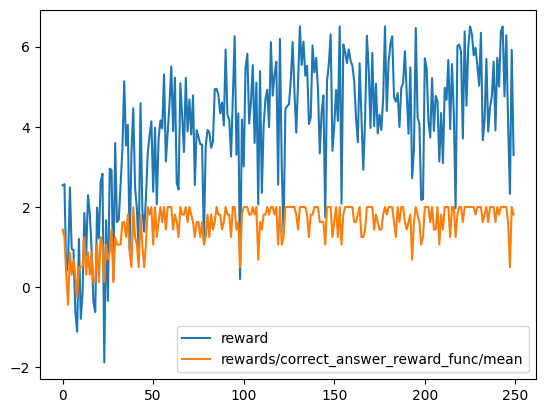

time: 3.15 s (started: 2025-12-24 13:36:05 +00:00)


In [15]:
# Show the total (sum) of the rewards as well as the correct_answer_reward_func (means with in the batch)
# Do you see the rewards increasing? Does the model get the correct answer
# more frequently toward the end?
# No changes needed in this cell

import pandas as pd
import matplotlib.pyplot as plt

# If you want to graph other columns, check these out
print(f"available columns: {trainer.state.log_history[0].keys()}")

log_df = pd.DataFrame(trainer.state.log_history)
log_df["reward"].plot()
log_df["rewards/correct_answer_reward_func/mean"].plot()

# Show the legend
plt.legend(["reward", "rewards/correct_answer_reward_func/mean"])
plt.show()

model.save_lora("grpo_saved_lora_overfitted")

In [5]:
from vllm import SamplingParams

# ==============================================================================
# 1. DEFINE THE DISTINCT PROMPTS
# ==============================================================================

# Prompt for BASE MODEL and GOOD LORA (The logic-based one)
SYSTEM_PROMPT_GOOD = """
You are a precise counting engine. To count letters accurately, you must first index the word character by character.

Respond in the following format:
<reasoning>
Target Word: [word]
Indexed:
1: [char]
2: [char]
...

Count logic:
1. [char] - [count of requested letter so far]
2. [char] - [count of requested letter so far]
...
The letter "[letter]" appears [number] times in the word "[word]".
</reasoning>
<answer>
[number]
</answer>
"""

# Prompt for OVERFITTED LORA (The specific training format it memorized)
SYSTEM_PROMPT_OVERFITTED = """
Respond in the following format:
<reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. [first letter] - [count of requested letter so far] so far
2. [second letter] - [count of requested letter so far] so far
...
</reasoning>
<answer>
[number]
</answer>
"""

# ==============================================================================
# 2. COMPARISON FUNCTION
# ==============================================================================

def run_test_case(word, letter):
    user_prompt = f'How many of the letter "{letter}" are there in the word "{word}"?'
    
    print(f"\n{'='*80}")
    print(f"❓ PROMPT: {user_prompt}")
    print(f"{'='*80}")

    sampling_params = SamplingParams(temperature=0.0, max_tokens=1024)

    # -------------------------------------------------------------------------
    # 1. BASE MODEL (Uses GOOD PROMPT)
    # -------------------------------------------------------------------------
    print("\n❌ === BASE MODEL ===")
    try:
        messages = [{"role": "system", "content": SYSTEM_PROMPT_GOOD}, {"role": "user", "content": user_prompt}]
        text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        output = model.fast_generate(text, sampling_params=sampling_params, lora_request=None)[0].outputs[0].text
        print(output.strip())
    except Exception as e:
        print(f"Error: {e}")

    # -------------------------------------------------------------------------
    # 2. GOOD LORA (Uses GOOD PROMPT)
    # -------------------------------------------------------------------------
    print("\n✅ === GOOD LORA (grpo_saved_lora) ===")
    try:
        messages = [{"role": "system", "content": SYSTEM_PROMPT_GOOD}, {"role": "user", "content": user_prompt}]
        text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        output = model.fast_generate(text, sampling_params=sampling_params, lora_request=model.load_lora("grpo_saved_lora"))[0].outputs[0].text
        print(output.strip())
    except Exception as e:
        print(f"Error: {e}")

    # -------------------------------------------------------------------------
    # 3. OVERFITTED LORA (Uses OVERFITTED PROMPT)
    # -------------------------------------------------------------------------
    print("\n💀 === OVERFITTED LORA (grpo_saved_lora_overfitted) ===")
    try:
        # NOTICE: We switch to SYSTEM_PROMPT_OVERFITTED here
        messages = [{"role": "system", "content": SYSTEM_PROMPT_OVERFITTED}, {"role": "user", "content": user_prompt}]
        text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        output = model.fast_generate(text, sampling_params=sampling_params, lora_request=model.load_lora("grpo_saved_lora_overfitted"))[0].outputs[0].text
        print(output.strip())
    except Exception as e:
        print(f"Error: {e}")


# ==============================================================================
# 3. EXECUTE THE TESTS
# ==============================================================================

print("\n\n🚨 ROUND 1: MEMORIZATION CHECK (Training Data) 🚨")
# These are from your dataset. Overfitted should ACE these because it memorized the answer key.
run_test_case("rust", "r")
run_test_case("fume", "e")


print("\n\n🚨 ROUND 2: SHORT UNSEEN WORDS (The 'Lookup Table' Proof) 🚨")
# These are simple words. Good LoRA should use logic to count.
# Overfitted LoRA will likely try to map them to a training word or fail logic.

# 1. "moon" (2 o's) - Very distinctive shape
run_test_case("moon", "o")

# 2. "noon" (2 n's) - Palindrome, simple
run_test_case("noon", "n")

# 3. "beep" (2 e's)
run_test_case("beep", "e")

# 4. "level" (2 l's)
run_test_case("level", "l")


print("\n\n🚨 ROUND 3: HARD UNSEEN WORDS (Stress Test) 🚨")
# Strawberry and Mississippi
run_test_case("strawberry", "r")
run_test_case("mississippi", "s")



🚨 ROUND 1: MEMORIZATION CHECK (Training Data) 🚨

❓ PROMPT: How many of the letter "r" are there in the word "rust"?

❌ === BASE MODEL ===


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 64.59 toks/s, output: 39.40 toks/s]


<reasoning>
Target Word: rust
Indexed:
1: r
2: u
3: s
4: t

Count logic:
1. r - 1
2. u - 1
3. s - 1
4. t - 1

The letter "r" appears 1 times in the word "rust".
</reasoning>
<answer>
1
</answer>

✅ === GOOD LORA (grpo_saved_lora) ===


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, est. speed input: 53.53 toks/s, output: 32.65 toks/s]


<reasoning>
Target Word: rust
Indexed:
1: r
2: u
3: s
4: t

Count logic:
1. r - 1
2. u - 1
3. s - 1
4. t - 1

The letter "r" appears 1 times in the word "rust".
</reasoning>
<answer>
1
</answer>

💀 === OVERFITTED LORA (grpo_saved_lora_overfitted) ===


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 51.43 toks/s, output: 31.84 toks/s]


<reasoning>
Counting the number of r's in the word rust
1. r - 1 so far
2. u - 1 so far
3. s - 1 so far
4. t - 1 so far
</reasoning>
<answer>
1
</answer>

❓ PROMPT: How many of the letter "e" are there in the word "fume"?

❌ === BASE MODEL ===


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 66.40 toks/s, output: 41.15 toks/s]


<reasoning>
Target Word: fume
Indexed:
1: f
2: u
3: m
4: e

Count logic:
1. f - 0
2. u - 1
3. m - 2
4. e - 3

The letter "e" appears 3 times in the word "fume".
</reasoning>
<answer>
3
</answer>

✅ === GOOD LORA (grpo_saved_lora) ===


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 53.04 toks/s, output: 32.87 toks/s]


<reasoning>
Target Word: fume
Indexed:
1: f
2: u
3: m
4: e

Count logic:
1. f - 0
2. u - 1
3. m - 1
4. e - 1

The letter "e" appears 1 times in the word "fume".
</reasoning>
<answer>
1
</answer>

💀 === OVERFITTED LORA (grpo_saved_lora_overfitted) ===


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 48.93 toks/s, output: 30.46 toks/s]


<reasoning>
Counting the number of e's in the word fume
1. f - 0 so far
2. u - 0 so far
3. m - 0 so far
4. e - 1 so far
</reasoning>
<answer>
1
</answer>


🚨 ROUND 2: SHORT UNSEEN WORDS (The 'Lookup Table' Proof) 🚨

❓ PROMPT: How many of the letter "o" are there in the word "moon"?

❌ === BASE MODEL ===


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 67.26 toks/s, output: 41.02 toks/s]


<reasoning>
Target Word: moon
Indexed:
1: m
2: o
3: o
4: n

Count logic:
1. m - 0
2. o - 1
3. o - 2
4. n - 2

The letter "o" appears 2 times in the word "moon".
</reasoning>
<answer>
2
</answer>

✅ === GOOD LORA (grpo_saved_lora) ===


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 51.48 toks/s, output: 32.86 toks/s]


<reasoning>
Target Word: moon
Indexed:
1: m
2: o
3: o
4: n

Count logic:
1. m - 0
2. o - 1
3. o - 1+1=2
4. n - 2

The letter "o" appears 2 times in the word "moon".
</reasoning>
<answer>
2
</answer>

💀 === OVERFITTED LORA (grpo_saved_lora_overfitted) ===


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 51.62 toks/s, output: 31.95 toks/s]


<reasoning>
Counting the number of o's in the word moon
1. m - 0 so far
2. o - 1 so far
3. o - 1 so far
4. n - 1 so far
</reasoning>
<answer>
1
</answer>

❓ PROMPT: How many of the letter "n" are there in the word "noon"?

❌ === BASE MODEL ===


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 67.34 toks/s, output: 41.07 toks/s]


<reasoning>
Target Word: noon
Indexed:
1: n
2: o
3: o
4: n

Count logic:
1. n - 1
2. o - 1
3. o - 2
4. n - 3

The letter "n" appears 3 times in the word "noon".
</reasoning>
<answer>
3
</answer>

✅ === GOOD LORA (grpo_saved_lora) ===


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 52.17 toks/s, output: 31.82 toks/s]


<reasoning>
Target Word: noon
Indexed:
1: n
2: o
3: o
4: n
Count logic:
1. n - 1
2. o - 1
3. o - 1
4. n - 1
The letter "n" appears 1 times in the word "noon".
</reasoning>
<answer>
1
</answer>

💀 === OVERFITTED LORA (grpo_saved_lora_overfitted) ===


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, est. speed input: 58.72 toks/s, output: 31.32 toks/s]


<reasoning>
Counting the number of n's in the word noon
1. n - 1 so far
2. o - 1 so far
3. o - 1 so far
</reasoning>
<answer>
1
</answer>

❓ PROMPT: How many of the letter "e" are there in the word "beep"?

❌ === BASE MODEL ===


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 62.62 toks/s, output: 41.01 toks/s]


<reasoning>
Target Word: beep
Indexed:
1: b
2: e
3: e
4: p

Count logic:
1. b - 0
2. e - 1
3. e - 1 + 1 = 2
4. p - 2

The letter "e" appears 2 times in the word "beep".
</reasoning>
<answer>
2
</answer>

✅ === GOOD LORA (grpo_saved_lora) ===


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 49.28 toks/s, output: 32.27 toks/s]


<reasoning>
Target Word: beep
Indexed:
1: b
2: e
3: e
4: p

Count logic:
1. b - 0
2. e - 1
3. e - 1 + 1 = 2
4. p - 2

The letter "e" appears 2 times in the word "beep".
</reasoning>
<answer>
2
</answer>

💀 === OVERFITTED LORA (grpo_saved_lora_overfitted) ===


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 49.37 toks/s, output: 32.14 toks/s]


<reasoning>
Counting the number of e's in the word beep
1. b - 0 so far
2. e - 1 so far
3. p - 1 so far
4. e - 1 (already counted) so far
</reasoning>
<answer>
1
</answer>

❓ PROMPT: How many of the letter "l" are there in the word "level"?

❌ === BASE MODEL ===


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it, est. speed input: 41.97 toks/s, output: 40.78 toks/s]


<reasoning>
Target Word: level
Indexed:
1: l
2: e
3: v
4: e
5: l

Count logic:
1. l - 1
2. e - 2 (previous count + 1 for the current character)
3. v - 3 (previous count + 1 for the current character)
4. e - 4 (previous count + 1 for the current character)
5. l - 5 (previous count + 1 for the current character)

The letter "l" appears 2 times in the word "level".
</reasoning>
<answer>
2
</answer>

✅ === GOOD LORA (grpo_saved_lora) ===


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it, est. speed input: 42.96 toks/s, output: 33.21 toks/s]


<reasoning>
Target Word: level
Indexed:
1: l
2: e
3: v
4: e
5: l

Count logic:
1. l - 1
2. e - 1
3. v - 1
4. e - 1 (previous count + 1)
5. l - 1 (previous count + 1)

The letter "l" appears 2 times in the word "level".
</reasoning>
<answer>
2
</answer>

💀 === OVERFITTED LORA (grpo_saved_lora_overfitted) ===


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 45.74 toks/s, output: 32.23 toks/s]


<reasoning>
Counting the number of l's in the word level
1. l - 1 so far
2. e - 1 so far
3. v - 1 so far
4. e - 1 so far
5. l - 2 so far
</reasoning>
<answer>
2
</answer>


🚨 ROUND 3: HARD UNSEEN WORDS (Stress Test) 🚨

❓ PROMPT: How many of the letter "r" are there in the word "strawberry"?

❌ === BASE MODEL ===


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.10s/it, est. speed input: 34.86 toks/s, output: 41.20 toks/s]


<reasoning>
Target Word: strawberry
Indexed:
1: s
2: t
3: r
4: r
5: a
6: w
7: b
8: r
9: r
10: a
11: y

Count logic:
1. s - 0
2. t - 1
3. r - 2
4. r - 3
5. a - 4
6. w - 5
7. b - 6
8. r - 7
9. r - 8
10. a - 9
11. y - 9

The letter "r" appears 3 times in the word "strawberry".
</reasoning>
<answer>
3
</answer>

✅ === GOOD LORA (grpo_saved_lora) ===


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.62s/it, est. speed input: 30.97 toks/s, output: 33.78 toks/s]


<reasoning>
Target Word: strawberry
Indexed:
1: s
2: t
3: r
4: r
5: a
6: w
7: b
8: r
9: r
10: a

Count logic:
1. s - 0
2. t - 1
3. r - 1
4. r - 2
5. a - 2
6. w - 2
7. b - 2
8. r - 3
9. a - 3
10. r - 4

The letter "r" appears 4 times in the word "strawberry".
</reasoning>
<answer>
4
</answer>

💀 === OVERFITTED LORA (grpo_saved_lora_overfitted) ===


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, est. speed input: 32.19 toks/s, output: 33.09 toks/s]


<reasoning>
Counting the number of r's in the word strawberry
1. s - 0 so far
2. t - 0 so far
3. r - 1 so far
4. a - 1 so far
5. w - 1 so far
6. b - 1 so far
7. r - 2 so far
8. e - 2 so far
9. r - 3 so far
</reasoning>
<answer>
3
</answer>

❓ PROMPT: How many of the letter "s" are there in the word "mississippi"?

❌ === BASE MODEL ===


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.07s/it, est. speed input: 20.10 toks/s, output: 42.05 toks/s]


<reasoning>
Target Word: mississippi
Indexed:
1: m
2: i
3: s
4: s
5: i
6: s
7: s
8: i
9: p
10: p
11: i
12: s
13: s
14: i
15: s
16: s
17: i
18: s
19: s
20: s
Count logic:
1. s - 0
2. s - 1
3. s - 2
4. s - 3
5. s - 3
6. s - 4
7. s - 5
8. s - 6
9. s - 7
10. s - 8
11. s - 9
12. s - 10
13. s - 11
14. s - 12
15. s - 13
16. s - 14
17. s - 15
18. s - 16
19. s - 17
20. s - 18
The letter "s" appears 18 times in the word "mississippi".
</reasoning>
<answer>
18
</answer>

✅ === GOOD LORA (grpo_saved_lora) ===


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it, est. speed input: 47.97 toks/s, output: 32.77 toks/s]


<reasoning>
Target Word: mississippi
Indexed:
1: m
2: i
3: s
4: s
5: i
6: s
7: i
8: p
9: p
10: i
11: s
12: i
13: s
The letter "s" appears 4 times in the word "mississippi".
</reasoning>
<answer>
4
</answer>

💀 === OVERFITTED LORA (grpo_saved_lora_overfitted) ===


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it, est. speed input: 27.07 toks/s, output: 33.46 toks/s]

<reasoning>
Counting the number of s's in the word mississippi
1. m - 0 so far
2. i - 0 so far
3. s - 1 so far
4. s - 1 so far
5. i - 1 so far
6. s - 2 so far
7. i - 2 so far
8. s - 3 so far
9. p - 3 so far
10. i - 3 so far
11. s - 4 so far
</reasoning>
<answer>
4
</answer>


In [8]:
from vllm import SamplingParams
import re

# ==============================================================================
# 1. SETUP (Prompts & Functions)
# ==============================================================================

SYSTEM_PROMPT_GOOD = """
You are a precise counting engine. To count letters accurately, you must first index the word character by character.

Respond in the following format:
<reasoning>
Target Word: [word]
Indexed:
1: [char]
2: [char]
...

Count logic:
1. [char] - [count of requested letter so far]
2. [char] - [count of requested letter so far]
...
The letter "[letter]" appears [number] times in the word "[word]".
</reasoning>
<answer>
[number]
</answer>
"""

SYSTEM_PROMPT_OVERFITTED = """
Respond in the following format:
<reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. [first letter] - [count of requested letter so far] so far
2. [second letter] - [count of requested letter so far] so far
...
</reasoning>
<answer>
[number]
</answer>
"""

def get_output(model, tokenizer, prompt, adapter_name, sys_prompt):
    messages = [{"role": "system", "content": sys_prompt}, {"role": "user", "content": prompt}]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    sampling_params = SamplingParams(temperature=0.0, max_tokens=1024)
    
    try:
        req = model.load_lora(adapter_name) if adapter_name else None
        output = model.fast_generate(text, sampling_params=sampling_params, lora_request=req)[0].outputs[0].text
        return output.strip()
    except Exception as e:
        return f"ERROR: {e}"

def print_result_block(title, prompt):
    print(f"\n{'='*80}")
    print(f"🧪 {title}")
    print(f"❓ {prompt}")
    print(f"{'-'*80}")
    
    # 1. BASE MODEL
    print("❌ BASE MODEL:")
    base_out = get_output(model, tokenizer, prompt, None, SYSTEM_PROMPT_GOOD)
    if "</reasoning>" in base_out:
        print(base_out.split('</reasoning>')[-1].strip())
    else:
        print(base_out) # Fallback if format is weird
    
    # 2. GOOD LORA
    print(f"\n✅ GOOD LORA:")
    good_out = get_output(model, tokenizer, prompt, "grpo_saved_lora", SYSTEM_PROMPT_GOOD)
    
    # FIX: Join the list into a string
    if "Count logic:" in good_out:
        lines = good_out.split("Count logic:")[-1].split("\n")[:5] # First 5 lines of logic
        print("Logic Snippet:\n" + "\n".join(lines).strip()) 
    
    if "</reasoning>" in good_out:
        print("Result: " + good_out.split('</reasoning>')[-1].strip())
    else:
        print("Result: [Format Error]")

    # 3. OVERFITTED LORA
    print(f"\n💀 OVERFITTED LORA:")
    bad_out = get_output(model, tokenizer, prompt, "grpo_saved_lora_overfitted", SYSTEM_PROMPT_OVERFITTED)
    
    # FIX: Join the list into a string
    if "<reasoning>" in bad_out:
        lines = bad_out.split("<reasoning>")[-1].split("\n")[1:5] # First few lines of logic
        print("Logic Snippet:\n" + "\n".join(lines).strip())
    
    if "</reasoning>" in bad_out:
        print("Result: " + bad_out.split('</reasoning>')[-1].strip())
    else:
        print("Result: [Format Error]")


# ==============================================================================
# 2. EXECUTE TESTS
# ==============================================================================

print("\n\n####################################################################")
print("🚨 PART A: 5 SAMPLES FROM TRAINING DATASET (Memorization Check) 🚨")
print("####################################################################")

# Using try/except in case DS indices are out of bounds for your specific subset
dataset_indices = [5, 15, 25, 35, 45] 

for idx in dataset_indices:
    try:
        if idx < len(ds):
            prompt_content = ds[idx]['prompt'][1]['content']
            print_result_block(f"Dataset Index {idx}", prompt_content)
    except Exception as e:
        print(f"Skipping index {idx}: {e}")


print("\n\n####################################################################")
print("🚨 PART B: 5 NEW UNSEEN WORDS (Generalization/Logic Check) 🚨")
print("####################################################################")

print_result_block("Unseen 1: Consecutive Doubles", 'How many of the letter "o" are there in the word "tooth"?')
print_result_block("Unseen 2: Split Duplicates", 'How many of the letter "p" are there in the word "paper"?')
print_result_block("Unseen 3: Triplets", 'How many of the letter "s" are there in the word "stats"?')
print_result_block("Unseen 4: Consecutive + Ending", 'How many of the letter "e" are there in the word "cheese"?')
print_result_block("Unseen 5: Repetitive Pattern", 'How many of the letter "m" are there in the word "minimum"?')



####################################################################
🚨 PART A: 5 SAMPLES FROM TRAINING DATASET (Memorization Check) 🚨
####################################################################

🧪 Dataset Index 5
❓ How many of the letter "g" are there in the word "glow"
--------------------------------------------------------------------------------
❌ BASE MODEL:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 64.31 toks/s, output: 39.40 toks/s]


<answer>
1
</answer>

✅ GOOD LORA:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 53.09 toks/s, output: 32.53 toks/s]


Logic Snippet:
1. g - 1
2. l - 1
3. o - 1
4. w - 1
Result: <answer>
1
</answer>

💀 OVERFITTED LORA:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 50.85 toks/s, output: 31.18 toks/s]


Logic Snippet:
Counting the number of g's in the word glow
1. g - 1 so far
2. l - 1 so far
3. o - 1 so far
Result: <answer>
1
</answer>

🧪 Dataset Index 15
❓ How many of the letter "a" are there in the word "maze"
--------------------------------------------------------------------------------
❌ BASE MODEL:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 65.61 toks/s, output: 40.02 toks/s]


<answer>
1
</answer>

✅ GOOD LORA:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 52.65 toks/s, output: 32.11 toks/s]


Logic Snippet:
1. m - 0
2. a - 1
3. z - 1
4. e - 1
Result: <answer>
1
</answer>

💀 OVERFITTED LORA:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 49.46 toks/s, output: 30.62 toks/s]


Logic Snippet:
Counting the number of a's in the word maze
1. m - 0 so far
2. a - 1 so far
3. z - 1 so far
Result: <answer>
1
</answer>

🧪 Dataset Index 25
❓ How many of the letter "i" are there in the word "wisp"
--------------------------------------------------------------------------------
❌ BASE MODEL:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 65.96 toks/s, output: 40.88 toks/s]


<answer>
1
</answer>

✅ GOOD LORA:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 52.73 toks/s, output: 32.68 toks/s]


Logic Snippet:
1. w - 0
2. i - 1
3. s - 1
4. p - 1
Result: <answer>
1
</answer>

💀 OVERFITTED LORA:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 51.05 toks/s, output: 31.78 toks/s]


Logic Snippet:
Counting the number of i's in the word wisp
1. w - 0 so far
2. i - 1 so far
3. s - 1 so far
Result: <answer>
1
</answer>

🧪 Dataset Index 35
❓ How many of the letter "h" are there in the word "lush"
--------------------------------------------------------------------------------
❌ BASE MODEL:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 66.88 toks/s, output: 40.79 toks/s]


<answer>
3
</answer>

✅ GOOD LORA:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 53.32 toks/s, output: 32.52 toks/s]


Logic Snippet:
1. l - 0
2. u - 1
3. s - 1
4. h - 1
Result: <answer>
1
</answer>

💀 OVERFITTED LORA:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 51.16 toks/s, output: 31.67 toks/s]


Logic Snippet:
Counting the number of h's in the word lush
1. l - 0 so far
2. u - 0 so far
3. s - 0 so far
Result: <answer>
1
</answer>

🧪 Dataset Index 45
❓ How many of the letter "i" are there in the word "knit"
--------------------------------------------------------------------------------
❌ BASE MODEL:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 58.50 toks/s, output: 40.79 toks/s]


<answer>
3
</answer>

✅ GOOD LORA:


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it, est. speed input: 46.62 toks/s, output: 32.50 toks/s]


Logic Snippet:
1. k - 0
2. n - 1
3. a - 1
4. i - 1
Result: <answer>
1
</answer>

💀 OVERFITTED LORA:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 49.11 toks/s, output: 30.58 toks/s]


Logic Snippet:
Counting the number of i's in the word knit
1. k - 0 so far
2. n - 0 so far
3. o - 0 so far
Result: <answer>
0
</answer>


####################################################################
🚨 PART B: 5 NEW UNSEEN WORDS (Generalization/Logic Check) 🚨
####################################################################

🧪 Unseen 1: Consecutive Doubles
❓ How many of the letter "o" are there in the word "tooth"?
--------------------------------------------------------------------------------
❌ BASE MODEL:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 53.10 toks/s, output: 40.76 toks/s]


<answer>
2
</answer>

✅ GOOD LORA:


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it, est. speed input: 40.88 toks/s, output: 33.10 toks/s]


Logic Snippet:
1. t - 0
2. h - 0
3. o - 1
4. o - 1 + 1 = 2
Result: <answer>
2
</answer>

💀 OVERFITTED LORA:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 40.82 toks/s, output: 31.96 toks/s]


Logic Snippet:
Counting the number of o's in the word tooth
1. t - 0 so far
2. o - 1 so far
3. o - 1 so far
Result: <answer>
3
</answer>

🧪 Unseen 2: Split Duplicates
❓ How many of the letter "p" are there in the word "paper"?
--------------------------------------------------------------------------------
❌ BASE MODEL:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 52.34 toks/s, output: 40.09 toks/s]


<answer>
2
</answer>

✅ GOOD LORA:


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it, est. speed input: 46.03 toks/s, output: 31.66 toks/s]


Logic Snippet:
1. p - 1
2. a - 1
3. p - 1
4. e - 1
Result: <answer>
2
</answer>

💀 OVERFITTED LORA:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 45.28 toks/s, output: 31.91 toks/s]


Logic Snippet:
Counting the number of p's in the word paper
1. p - 1 so far
2. a - 1 so far
3. p - 2 so far
Result: <answer>
2
</answer>

🧪 Unseen 3: Triplets
❓ How many of the letter "s" are there in the word "stats"?
--------------------------------------------------------------------------------
❌ BASE MODEL:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 57.58 toks/s, output: 39.61 toks/s]


<answer>
2
</answer>

✅ GOOD LORA:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  3.00s/it, est. speed input: 47.10 toks/s, output: 32.40 toks/s]


Logic Snippet:
1. s - 1
2. t - 1
3. a - 1
4. t - 1
Result: <answer>
2
</answer>

💀 OVERFITTED LORA:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 44.71 toks/s, output: 31.51 toks/s]


Logic Snippet:
Counting the number of s's in the word stats
1. s - 1 so far
2. t - 1 so far
3. s - 2 so far
Result: <answer>
3
</answer>

🧪 Unseen 4: Consecutive + Ending
❓ How many of the letter "e" are there in the word "cheese"?
--------------------------------------------------------------------------------
❌ BASE MODEL:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, est. speed input: 50.60 toks/s, output: 38.84 toks/s]


<answer>
4
</answer>

✅ GOOD LORA:


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it, est. speed input: 35.67 toks/s, output: 32.41 toks/s]


Logic Snippet:
1. c - 0
2. h - 0
3. e - 1 (first 'e')
4. e - 1 (first 'e') + 1 (second 'e') = 2
Result: <answer>
2
</answer>

💀 OVERFITTED LORA:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 40.11 toks/s, output: 31.40 toks/s]


Logic Snippet:
Counting the number of e's in the word cheese
1. c - 0 so far
2. h - 0 so far
3. e - 1 so far
Result: <answer>
1
</answer>

🧪 Unseen 5: Repetitive Pattern
❓ How many of the letter "m" are there in the word "minimum"?
--------------------------------------------------------------------------------
❌ BASE MODEL:


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.58s/it, est. speed input: 30.83 toks/s, output: 41.33 toks/s]


<answer>
5
</answer>

✅ GOOD LORA:


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.96s/it, est. speed input: 35.67 toks/s, output: 32.89 toks/s]


Logic Snippet:
1. m - 1
2. i - 1
3. n - 1
4. u - 1
Result: <answer>
2
</answer>

💀 OVERFITTED LORA:


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 40.44 toks/s, output: 31.97 toks/s]

Logic Snippet:
Counting the number of m's in the word minimum
1. m - 1 so far
2. i - 1 so far
3. n - 1 so far
Result: <answer>
2
</answer>


## We see that "Good LoRA" is a bit better on unknown words than "Overfitted" however both struggling with the long words and not following reasoning structure strictly.

### Possibly longer training could help model to identify the correct way of following reasoning logic, but we need to do so on a larger words dataset to exclude memorizing of the right answers

## Experiment Summary

- Compared two training setups: author-recommended hyperparams vs. custom setup (lower LoRA rank 32, adjusted GRPO params).
- Expanded vocabulary to reduce memorization risk and encourage generalization.
- Rewrote spelling reward to parse the indexed spelling section and compare to ground-truth words.
- Added majority voting mechanism.
- Evaluated on known and unseen words across three models: base, author-tuned, and custom-tuned; tuned models outperform base with noted differences in stress tests.
- Prompt updated with explicit letters indexing + CoT few-shots; improves spelling/count accuracy at the cost of more tokens and slightly slower runs.
- Reward functions (numbering, spelling, counting, format, correct answer) completed and tested; catastrophic forgetting check run on a general-knowledge question (both OLD/NEW correct).

In [25]:
# Demo

# Final side-by-side check on the original baseline prompt ("engage")
# Uses the same `text_for_completion` built above so we can visually compare
# the base model, the GRPO LoRA, and the overfitted LoRA on identical input.

from vllm import SamplingParams

sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=2048)

print("=== BASE MODEL (no LoRA) ===")
base_output = model.fast_generate(
    [text_for_completion],
    sampling_params=sampling_params,
    lora_request=None,
)[0].outputs[0].text
print(base_output.strip())

print("\n=== GRPO LoRA (grpo_saved_lora) ===")
good_output = model.fast_generate(
    [text_for_completion],
    sampling_params=sampling_params,
    lora_request=model.load_lora("grpo_saved_lora"),
)[0].outputs[0].text
print(good_output.strip())

print("\n=== GRPO Overfitted LoRA (grpo_saved_lora_overfitted) ===")
overfit_output = model.fast_generate(
    [text_for_completion],
    sampling_params=sampling_params,
    lora_request=model.load_lora("grpo_saved_lora_overfitted"),
)[0].outputs[0].text
print(overfit_output.strip())



=== BASE MODEL (no LoRA) ===


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it, est. speed input: 115.29 toks/s, output: 39.65 toks/s]


<reasoning>
Target Word: engage
Indexed:
1: e
2: n
3: g
4: a
5: n
6: g
7: e

Count logic:
1. e - 0
2. n - 0
3. g - 0
4. a - 1
5. n - 1
6. g - 1
7. e - 1
The letter "g" appears 1 times in the word "engage".
</reasoning>
<answer>
1
</answer>

=== GRPO LoRA (grpo_saved_lora) ===


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it, est. speed input: 102.55 toks/s, output: 32.01 toks/s]


<reasoning>
Target Word: engage
Indexed:
1: e
2: n
3: g
4: a
5: n
6: g

Count logic:
1. e - 0
2. n - 0
3. g - 1
4. a - 1
5. n - 1
6. g - 2
The letter "g" appears 2 times in the word "engage".
</reasoning>
<answer>
2
</answer>

=== GRPO Overfitted LoRA (grpo_saved_lora_overfitted) ===


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it, est. speed input: 104.47 toks/s, output: 32.61 toks/s]

<reasoning>
Target Word: engage
Indexed:
1: e
2: n
3: g
4: a
5: n
6: e

Count logic:
1. e - 0
2. n - 0
3. g - 0
4. a - 0
5. n - 1
6. e - 1
The letter "g" appears 1 times in the word "engage".
</reasoning>
<answer>
1
</answer>
time: 9.71 s (started: 2025-12-25 16:10:23 +00:00)


In [27]:
# Repeat the side-by-side comparison on two more early examples using the same sampling params
more_cases = [
    ("quick", "c"),   # classic example from the intro
    ("banana", "n"), # also shown in the early prompt examples
]

sampling_params_extra = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=2048)

for word, letter in more_cases:
    user_prompt = f'How many of the letter "{letter}" are there in the word "{word}"'
    text_fc = tokenizer.apply_chat_template(
        conversation=[{"role": "system", "content": SYSTEM_PROMPT}, {"role": "user", "content": user_prompt}],
        tokenize=False,
        add_generation_prompt=True,
    )
    print("\n" + "="*80)
    print(f"Prompt: {user_prompt}")
    print("-"*80)
    base_out = model.fast_generate([text_fc], sampling_params=sampling_params_extra, lora_request=None)[0].outputs[0].text
    print("BASE:\n" + base_out.strip())
    good_out = model.fast_generate([text_fc], sampling_params=sampling_params_extra, lora_request=model.load_lora("grpo_saved_lora"))[0].outputs[0].text
    print("\nGRPO LoRA:\n" + good_out.strip())
    overfit_out = model.fast_generate([text_fc], sampling_params=sampling_params_extra, lora_request=model.load_lora("grpo_saved_lora_overfitted"))[0].outputs[0].text
    print("\nGRPO Overfitted LoRA:\n" + overfit_out.strip())




Prompt: How many of the letter "c" are there in the word "quick"
--------------------------------------------------------------------------------


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 136.86 toks/s, output: 38.93 toks/s]


BASE:
<reasoning>
Target Word: quick
Indexed:
1: q
2: u
3: i
4: c
5: k

Count logic:
1. q - 0
2. u - 0
3. i - 0
4. c - 0
5. k - 0
The letter "c" appears 0 times in the word "quick".
</reasoning>
<answer>
0
</answer>


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 113.48 toks/s, output: 32.28 toks/s]



GRPO LoRA:
<reasoning>
Target Word: quick
Indexed:
1: q
2: u
3: i
4: c
5: k

Count logic:
1. q - 0
2. u - 0
3. i - 0
4. c - 1
5. k - 1
The letter "c" appears 1 times in the word "quick".
</reasoning>
<answer>
1
</answer>


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it, est. speed input: 112.08 toks/s, output: 31.88 toks/s]



GRPO Overfitted LoRA:
<reasoning>
Target Word: quick
Indexed:
1: q
2: u
3: i
4: c
5: k

Count logic:
1. q - 0
2. u - 0
3. i - 0
4. c - 0
5. k - 0

The letter "c" appears 0 times in the word "quick".
</reasoning>
<answer>
0
</answer>

Prompt: How many of the letter "n" are there in the word "banana"
--------------------------------------------------------------------------------


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 128.29 toks/s, output: 40.63 toks/s]


BASE:
<reasoning>
Target Word: banana
Indexed:
1: b
2: a
3: n
4: a
5: n
6: a

Count logic:
1. b - 0
2. a - 1
3. n - 1
4. a - 2
5. n - 2
6. a - 3
The letter "n" appears 2 times in the word "banana".
</reasoning>
<answer>
2
</answer>


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, est. speed input: 102.59 toks/s, output: 32.49 toks/s]



GRPO LoRA:
<reasoning>
Target Word: banana
Indexed:
1: b
2: a
3: n
4: a
5: n
6: a

Count logic:
1. b - 0
2. a - 0
3. n - 1
4. a - 1
5. n - 2
6. a - 2
The letter "n" appears 2 times in the word "banana".
</reasoning>
<answer>
2
</answer>


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, est. speed input: 102.42 toks/s, output: 32.44 toks/s]


GRPO Overfitted LoRA:
<reasoning>
Target Word: banana
Indexed:
1: b
2: a
3: n
4: a
5: n
6: a

Count logic:
1. b - 0
2. a - 0
3. n - 1
4. a - 1
5. n - 2
6. a - 2
The letter "n" appears 2 times in the word "banana".
</reasoning>
<answer>
2
</answer>
time: 17.9 s (started: 2025-12-25 16:12:56 +00:00)
